In [1]:
#Importing libraries:
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Importing regex:
import regex as re

#Importing WordNetLemmatizer:
from nltk.stem import WordNetLemmatizer
#Instantiating WordNetLemmatizer()
lemmatizer = WordNetLemmatizer()

#Importing stopwords (the stop word list)
from nltk.corpus import stopwords

# Importing train_test_split.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Importing CountVectorizer.
from sklearn.feature_extraction.text import CountVectorizer

#Importing LogisticRegression
from sklearn.linear_model import LogisticRegression

### Assumption

Note that we are assuming that posts in r/climate are typically written by global climate change believers while posts in r/climateskeptics are typically written by global climate change skeptics.

### Importing Data

Importing data saved in csv's to pandas dataframes:

In [2]:
df_climate_1 = pd.read_csv('../data/climate_posts_detailed_20190401_0955.csv')

In [3]:
df_climate_2 = pd.read_csv('../data/climate_posts_detailed_20190402_2100.csv')

In [4]:
df_skeptics_1 = pd.read_csv('../data/skeptics_posts_detailed_20190401_1040.csv')

In [5]:
df_skeptics_2 = pd.read_csv('../data/skeptics_posts_detailed_20190403_0640.csv')

Checking the dataframe heads:

In [6]:
#df_climate_1.head()
#df_climate_2.head()
#df_skeptics_1.head()
#df_skeptics_2.head()

### Data Cleaning and Exploratory Data Analysis (EDA) 

Noticed there is a column that has index values from the original data - removing that next

Note that Sam Stack helped with this during an NLP session.

In [7]:
df_climate_1.drop(columns = 'Unnamed: 0', inplace = True)
df_climate_2.drop(columns = 'Unnamed: 0', inplace = True)
df_skeptics_1.drop(columns = 'Unnamed: 0', inplace = True)
df_skeptics_2.drop(columns = 'Unnamed: 0', inplace = True)

In [8]:
#Checking work:
#df_climate_1.head()
#df_climate_2.head()
#df_skeptics_1.head()
#df_skeptics_2.head()

Combining df_climate_1 and df_climate_2

In [9]:
df_climate_1.shape

(977, 5)

In [10]:
df_climate_2.shape

(976, 5)

In [11]:
df_climate = pd.concat([df_climate_1, df_climate_2], axis = 0)

In [12]:
#Checking work:
#df_climate.head()
#df_climate.shape
#977+976
#df_climate[975:980]

In [13]:
#Resetting indices
df_climate.reset_index(drop=True, inplace=True)

In [14]:
#Checking work:
#df_climate[975:980]

Combining df_skeptics_1 and df_skeptics_2

In [15]:
df_skeptics_1.shape

(999, 5)

In [16]:
df_skeptics_2.shape

(1000, 5)

In [17]:
df_skeptics = pd.concat([df_skeptics_1, df_skeptics_2], axis = 0)

In [18]:
#Checking work:
#df_skeptics.head()
#df_skeptics.shape
#999+1000
#df_skeptics[998:1003]

In [19]:
#Resetting indices
df_skeptics.reset_index(drop=True, inplace=True)

In [20]:
#Checking work:
#df_skeptics[998:1003]

Creating target column called skeptic.  If the post is from r/climate, a 0 is placed in the skeptic column.  If the post is from r/climateskeptics, a 1 is placed in the skeptic column. 

In [21]:
#Adding target column to df_climate: (0: /r/climate post, 1: /r/climateskeptics post)
df_climate['skeptic'] = 0

In [22]:
#Adding target column to df_skeptics: (0: /r/climate post, 1: /r/climateskeptics post)
df_skeptics['skeptic'] = 1

Creating a df with both df_climate and df_skeptics df's combined:

In [23]:
df_diff_indices = pd.concat([df_climate, df_skeptics], axis = 0)

#Source:
#http://chris.friedline.net/2015-12-15-rutgers/lessons/python2/04-merging-data.html

In [24]:
#Resetting indices
df = df_diff_indices.reset_index(drop=True) 

In [25]:
#Checking work:
df_climate.shape[0] + df_skeptics.shape[0]

3952

In [26]:
df.shape

(3952, 6)

Removing duplicate rows

In [27]:
df.drop_duplicates(subset = 'title', inplace=True)
df.reset_index(drop=True, inplace=True)

In [28]:
#Checking the size significantly decreased:
df.shape

(1997, 6)

In [29]:
df_climate.shape 

(1953, 6)

In [30]:
df_skeptics.shape

(1999, 6)

In [31]:
df['skeptic'].value_counts()

1    1002
0     995
Name: skeptic, dtype: int64

In [32]:
df['skeptic'].value_counts()[1] - df_skeptics_2.shape[0] 

2

In [33]:
df['skeptic'].value_counts()[0] - df_climate_2.shape[0] 

19

It looks like a lot of the data collected a day after the initial dataset was collected does not contain much non-duplicate information.  It looks like after a day, only two posts were added to the r/climateskeptics subreddit, and only 19 posts were added to the r/clime subreddit.  I hoped that I could have collected more subreddit post titles, but I ran into time constraints (unfortunately I collected posts last week, but the format was not optimal for data processing - at some point, I might dig into that data as well).  I might use the post body text and comments for analysis later (depending on time and other factors).

Checking to see if there are any null values in the df dataframe:
(also finding the proportion of null values to all values in the columns with null values: post_text in the dataframe)

In [34]:
df.isnull().sum()[df.isnull().sum() != 0].sort_values(ascending = False) 

post_text    1789
dtype: int64

In [35]:
df.shape

(1997, 6)

In [36]:
#Looking at proportion of post_text values that are null values (out of all of the post_text cells):
df['post_text'].isnull().sum() / df.shape[0]

0.8958437656484727

In [37]:
#Looking at proportion of climate believer post_text values that are null values
#(out of all of the post_text cells):
df[df['skeptic'] == 0]['post_text'].isnull().sum() / df.shape[0]

0.4501752628943415

In [38]:
#Looking at proportion of climate skeptic post_text values that are null values
#(out of all of the post_text cells):
df[df['skeptic'] == 1]['post_text'].isnull().sum() / df.shape[0]

0.4456685027541312

Note that the majority of posts subreddits in the df do not contain post text.  Therefore, post text will probably not be analyzed at this time.

Filling post text null values with empty strings just in case the post text are analyzed in the future:

In [39]:
df['post_text'].fillna('', inplace = True)

In [40]:
#Checking no null values remaining:
df.isnull().sum()[df.isnull().sum() != 0].sort_values(ascending = False) 

Series([], dtype: int64)

In [41]:
#Checking datatypes of df:
df.dtypes

title                           object
full_post                       object
permalink                       object
post_text                       object
full_comments_page_each_post    object
skeptic                          int64
dtype: object

The datatypes are mostly objects, and the skeptic column is filled with integers (0 or 1), as expected.

In [42]:
df.head()

,title,full_post,permalink,post_text,full_comments_page_each_post,skeptic
0,What is anomalous? The stabilisation of CH₄ co...,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b8364j/what_is_anomalous_t...,,[],0
1,Global carbon emissions hit record high in 201...,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b82tsw/global_carbon_emiss...,,[],0
2,"U.S. judge scraps Trump order opening Arctic, ...","{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b82cw2/us_judge_scraps_tru...,,[],0
3,Ocasio-Cortez slams critics who would wait on ...,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b826lv/ocasiocortez_slams_...,,[],0
4,Save the climate,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b8214y/save_the_climate/,"Ok, we need to save the climate. Start to post...",[],0


In [43]:
#Setting target variable:
target = df['skeptic'] #1 if skeptic, 0 if believer (in global climate change)

In [44]:
#Checking value counts of the target variable:
target.value_counts()

1    1002
0     995
Name: skeptic, dtype: int64

In [45]:
#Checking value counts proportions of the target variable:
target.value_counts(normalize=True)

1    0.501753
0    0.498247
Name: skeptic, dtype: float64

There are 1002 r/climateskeptics posts and 995 r/climate posts.  There is a pretty good balance in the target class.  

The baseline model is predicting that every post is in the majority class, meaning the post is in the r/climateskeptics subreddit page. The accuracy of the baseline model is approx. 0.502 (meaning 50.2% of predictions are correct).  The goal is to beat this baseline model accuracy of 0.502.  

#### Inspecting total character counts and total word counts

In [46]:
#Creating a column with character counts for each post title:
df['char_count'] = df['title'].map(len)

In [47]:
#Creating a column with word counts for each post title:
df['word_count'] = df['title'].map(lambda x: len(x.split()))

In [48]:
#Checking work:
#df.head()

#### Looking at some distributions

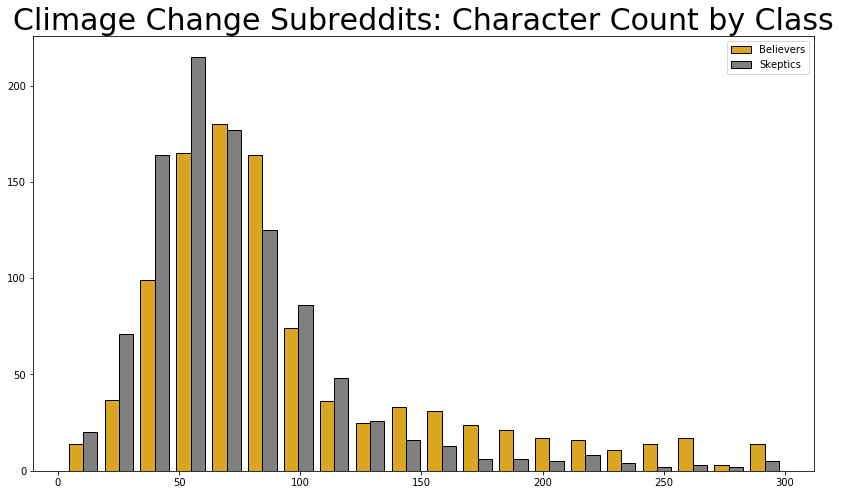

In [49]:
plt.figure(figsize=(14,8))
plt.hist([df[df['skeptic']==0]['char_count'], 
          df[df['skeptic']==1]['char_count']],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Climage Change Subreddits: Character Count by Class', fontsize=30)
plt.legend(['Believers', 'Skeptics']);

Interesting observations:  
- Skeptics more often have shorter post titles (based on number of characters).
- Therefore, climate believers are more likely to have longer post titles (based on number of characters).
- Upper outliers seem to be more likely believers.
- The believers and skeptics distributions (of post title character length) are both skewed to the right, but there is a larger skew to the right for the believers distribution. 

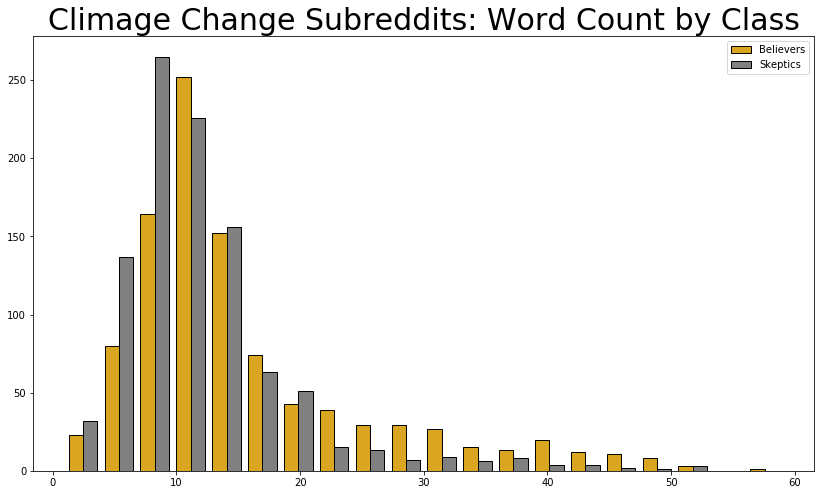

In [50]:
plt.figure(figsize=(14,8))
plt.hist([df[df['skeptic']==0]['word_count'], 
          df[df['skeptic']==1]['word_count']],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Climage Change Subreddits: Word Count by Class', fontsize=30)
plt.legend(['Believers', 'Skeptics']);

Interesting observations:  
- Skeptics more often have shorter post titles (based on number of words).
- Therefore, climate believers are more likely to have longer post titles (based on number of words).
- Upper outliers seem to be more likely believers.
- The believers and skeptics distributions (of post title word count) are both skewed to the right, but there is a larger skew to the right for the believers distribution. 

#### Text PreProcessing

In [51]:
#Function to preprocess text-based data:
def text_preprocessing(text_data): #text_data is a column which acts like a list of string objects
    text_data_preprocessed = []
    for elem in text_data: #elem is a section of text (element in the list of sections of text)
        
        #converting the text element to lowercase:
        elem_lower_case = elem.lower()
        
        #removing puctuation from the lower-case text element (keeping numbers and letters):
        elem_no_punctuation = re.sub("[^a-zA-Z0-9]",           # The pattern to search for
                                     " ",                      # The pattern to replace it with
                                     elem_lower_case)          # The text to search
        
        #Tokenizing (splitting up words:
        tokens = elem_no_punctuation.split()
        
        #Lemmatizing each word of the text element:
        tokens_lem = [lemmatizer.lemmatize(i) for i in tokens]
        
        #Removing stopwords:
        elem_no_stopwords = [token for token in tokens_lem if token not in stopwords.words('english')]
        
        #Joining the words back into one string separated by space, 
        # and return the result.
        text_data_preprocessed_string = (" ".join(elem_no_stopwords))
        
        #Placing the preprocessed string into text_data_preprocessed
        text_data_preprocessed.append(text_data_preprocessed_string)
    
    return text_data_preprocessed                 

#Source:
#Matt Brems helped with this during an NLP session.

In [52]:
df['title_preprocessed'] = text_preprocessing(df['title'])

Looking at how the text_preprocessed changed the first title

In [53]:
df['title'][0]

'What is anomalous? The stabilisation of CH₄ concentrations from 2000-2007 or the renewed growth from 2007 onward? Are we looking under the wrong rock: are we looking for decreased sources &amp; increased sink or increased sources &amp; decreased sink?'

In [54]:
df['title_preprocessed'][0]

'anomalous stabilisation ch concentration 2000 2007 renewed growth 2007 onward looking wrong rock looking decreased source amp increased sink increased source amp decreased sink'

It looks like the text is all lower-case, the punctuation was removed, and the words were lemmatized.  It's interesting that the chemical formala for methane was cut from CH4 to ch.  This might be an issue if a lot of people refer to methane as CH4.

#### Creating Matrix of CountVectorized Post Titles

In [55]:
# Instantiating the "CountVectorizer" object, which is scikit-learn's bag of words tool.
cvec = CountVectorizer(stop_words='english', 
                       min_df=5,    #at least 5 occurrences of the word needed to be placed in word matrix
                       max_df=0.99) #if a word occurs in over 99% of observations, it will not be included
                                    #in analysis (percent of observation word is allowed in)
    
#Source:
#Matt Brems helped with this during an NLP session.

Checking the datatype of df['title_preprocessed'] 
(needs to be a list of stings to use CountVectorizer to process it):

In [56]:
type(df['title_preprocessed'])

pandas.core.series.Series

In [57]:
#CountVectorizing the data (counting number of each word in each observation (without the stop words)):
term_matrix = cvec.fit_transform(df['title_preprocessed'].tolist())
term_matrix
#Source:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.tolist.html

<1997x692 sparse matrix of type '<class 'numpy.int64'>'
	with 10598 stored elements in Compressed Sparse Row format>

In [58]:
#Finding the number of words that were CountVectorized:
len(cvec.get_feature_names())

692

In [59]:
#Placing the word matrix into a word dataframe (and looking at the head of the df):
term_df = pd.DataFrame(term_matrix.toarray(), columns=cvec.get_feature_names())
term_df.head()

,000,10,100,11,12,15,17,20,200,2016,...,worried,worse,worst,worth,wrong,year,york,young,youth,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
our_target = df['skeptic']

In [61]:
term_df.insert(0, 'our_target', our_target) 
#moved the our_target column (with 1=skeptic and 0=believer) to the left-most column

#Checking work:
term_df.head()

,our_target,000,10,100,11,12,15,17,20,200,...,worried,worse,worst,worth,wrong,year,york,young,youth,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
#Checking shape of the words df:
term_df.shape

(1997, 693)

In [63]:
#Changing options so can see more columns when look at head of words_df:
pd.set_option('display.max_columns', 700)
term_df.head()

,our_target,000,10,100,11,12,15,17,20,200,2016,2018,2019,2020,2050,2080,25,30,35,40,50,58,60,academic,accept,access,according,act,action,activism,activist,activity,actual,actually,adam,address,administration,affect,age,agenda,ago,agree,air,al,alarmism,alarmist,alexandria,alternative,ambitious,america,american,amp,analysis,answer,antarctic,antarctica,anti,aoc,apocalypse,approach,arctic,area,argument,article,assessment,atlantic,atmosphere,atmospheric,australia,australian,author,average,away,bad,bank,bankruptcy,banned,bbc,bear,belief,believe,benefit,bernie,best,better,big,biggest,billion,blame,block,blog,bomb,book,break,bring,build,building,built,burning,business,california,calling,came,campaign,canada,canadian,capitalism,capture,car,carbon,case,cash,catastrophe,catastrophic,cause,caused,century,challenge,chance,change,changing,chaos,check,chief,child,china,citizen,city,claim,clean,clear,climate,climatologist,cloud,co2,coal,cold,colder,coldest,collapse,colorado,combat,come,coming,comment,committee,community,company,completely,complex,condition,congress,consensus,conservative,conspiracy,consumption,contribute,control,conversation,cool,cooling,coral,corporate,cortez,cost,country,court,create,crisis,cut,cyclone,dangerous,data,david,day,deal,death,debate,debunking,debunks,decade,decline,deep,degree,delingpole,demand,democrat,democratic,denial,denier,despite,destroying,developing,dioxide,disaster,discussion,disease,doe,donald,doubt,dr,drilling,driven,drop,drought,dutch,dying,earth,economic,effect,effort,electric,electricity,emergency,emission,end,ending,energy,entire,environment,environmental,epa,europe,european,event,evidence,expected,expert,explain,explains,explanation,expose,extinction,extreme,face,fact,failing,failure,fake,family,far,farm,faster,fear,february,federal,feel,feinstein,fight,fighting,finding,fish,fix,flood,flooding,focus,food,force,forest,fossil,founder,fox,fraud,free,friday,fuel,funding,future,gas,general,generation,geoengineering,german,germany,given,glacier,global,goal,going,gold,good,google,gop,gore,got,government,graph,great,green,greenhouse,greenland,greenpeace,greta,group,growing,growth,guide,guy,ha,half,happened,hawaii,head,health,hearing,heat,heatwave,heavy,hell,heller,help,high,higher,historical,history,hit,hoax,hockey,home,hope,hot,hottest,house,huge,human,humanity,hysteria,ice,idea,ignores,immediate,impact,important,including,increase,increased,increasing,industrial,industry,infrastructure,insane,inslee,inspired,instead,interview,ipcc,island,issue,jay,jet,job,john,join,joke,judge,justice,key,kid,kill,know,lake,land,large,latest,law,lawmaker,lawsuit,le,lead,leading,led,left,let,letter,level,liberal,lie,life,light,like,likely,line,link,list,little,live,lobbying,lobbyist,long,look,looking,losing,loss,low,magazine,major,make,making,man,mann,map,march,marine,massive,mayor,mcconnell,mean,measure,medium,meet,melt,melting,member,methane,metric,michael,midwest,mike,million,min,mind,minimum,minute,missing,mitch,model,modern,money,month,moore,movement,myth,narrative,nasa,nation,national,natural,nature,nearly,need,needed,negative,new,news,noaa,non,nonsense,north,northern,nuclear,number,observation,ocasio,ocean,office,official,oil,old,open,organization,outside,page,panel,panic,paper,paris,party,past,patrick,pay,people,percent,pg,physicist,pick,picture,pipeline,place,plan,planet,plant,pledge,podcast,point,polar,pole,policy,political,politician,politics,pollution,poor,population,post,power,prediction,president,presidential,prevent,price,pricing,private,problem,process,production,project,proof,proposal,protest,public,push,question,race,radical,rain,raise,rare,rate,read,real,reality,really,reason,recent,record,reduce,reducing,reduction,reef,refugee,related,renewable,renewables,report,representative,republican,research,researcher,resolution,result,reveals,review,right,rise,rising,risk,rule,running,safe,said,save,say,scale,scam,scare,scenario,school,science,scientific,scientist,scott,sea,security,seen,senate,senator,sense,se

#### Looking at most frequently appearing words

In [64]:
term_counts = { col : term_df[col].sum() for col in term_df.columns[1:]} 
#summing all columns and connecting sums to col names
tcd = pd.DataFrame(term_counts, index = ['counts'])

tcd = tcd.T

tcd.head()

,counts
000,15
10,14
100,18
11,8
12,10


In [65]:
#Looking at the 15 most common words in climate and climate skeptics post titles
tcd.sort_values(by = 'counts', ascending = False).head(15) 

,counts
climate,976
change,515
new,258
green,188
global,180
warming,165
deal,161
science,97
year,78
carbon,77


In [66]:
#Looking at the 30 most common words in climate and climate skeptics post titles
tcd.sort_values(by = 'counts', ascending = False).head(30)

,counts
climate,976
change,515
new,258
green,188
global,180
warming,165
deal,161
science,97
year,78
carbon,77


In [67]:
# Taking the top 15 most appearing words
top15 = list(tcd.sort_values(by = 'counts', 
                             ascending = False).head(15).index)

top15.append('our_target') #target added to make viz below - getting correlation
top15

['climate',
 'change',
 'new',
 'green',
 'global',
 'warming',
 'deal',
 'science',
 'year',
 'carbon',
 'world',
 'trump',
 'scientist',
 'emission',
 'ha',
 'our_target']

In [68]:
# Taking the 16th to 30th most appearing words in r/climate and r/climateskeptics
next15 = list(tcd.sort_values(by = 'counts', 
                             ascending = False)[15:30].index)

next15.append('our_target') #target added to make viz below - getting correlation
next15

['time',
 'say',
 'energy',
 'co2',
 'record',
 'temperature',
 'need',
 'fuel',
 'ice',
 'earth',
 'people',
 'fossil',
 'coal',
 'action',
 'sea',
 'our_target']

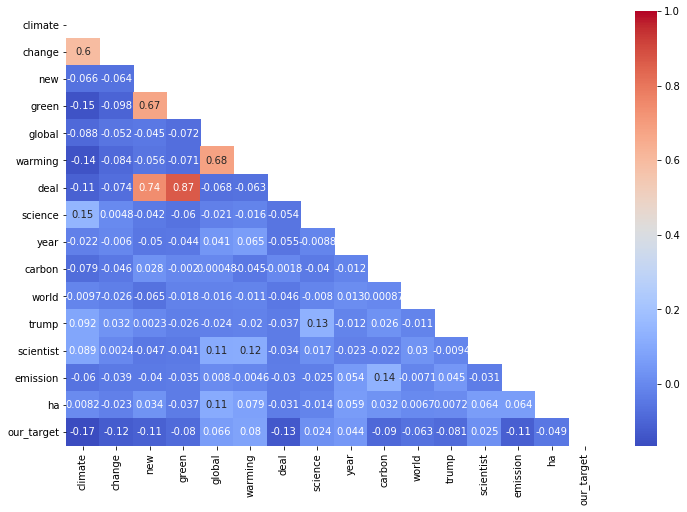

In [69]:
#Looking at the top 15 words that appear in both climate and climate skeptics posts and how correlate to 
#each other and whether global climate change skeptic (1) or believer (0)
plt.figure(figsize = (12,8))

corr = term_df[top15].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True); 
#could use viridis instead of coolwarm too

It appears that "climate" and "change" and "global" and "warming" are highly correlated with each other probably because climate change and global warming are very common topics in the r/climate and r/climateskeptics subreddits.  Also, "green" and "new", "new" and "deal", "green" and "deal" appear to be highly correlated probably because there is a lot of discussion about the Green New Deal currently.   

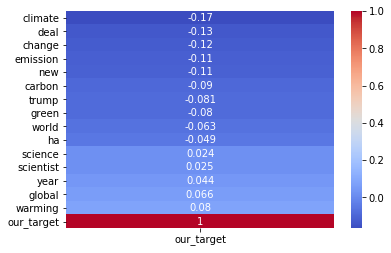

In [70]:
#Looking at the top 15 words that appear in both climate and climate skeptics posts and how correlate to 
#whether global climate change skeptic (1) or believer (0)
sns.heatmap(term_df[top15].corr()[['our_target']].sort_values('our_target'), annot=True, cmap='coolwarm')

It looks like global climate change skeptics use the following words often in their post titles (because they have the highest correlation with being in a climate skeptic subreddit (out of the top 15 words found in the r/climate and r/climateskeptics subreddits)):
- warming
- global
- year
- scientist
- science

It looks like global climate change believers use the following words often in their post titles (because they have negative correlation with being in a climate skeptic subreddit (out of the top 15 words found in the r/climate and r/climateskeptics subreddits)):
- climate
- deal
- change
- emission
- new
- carbon
- Trump
- green
- world
- (ha (this word was probably cut improperly during lemmitization))

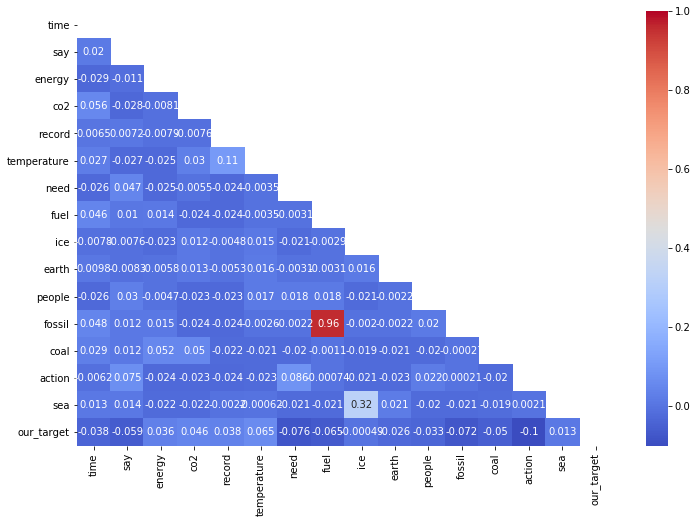

In [71]:
#Looking at the 16th to 30th most common words that appear in both climate and climate skeptics posts and 
#how correlate to each other and whether global climate change skeptic (1) or believer (0)
plt.figure(figsize = (12,8))

corr = term_df[next15].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True); 

It looks like "fossil" and "fuel" are highly correlated with each other.  It also looks like "sea" and "ice" are highly correlated with each other.

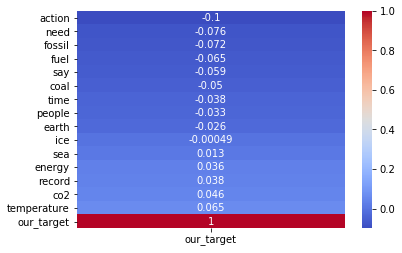

In [72]:
#Looking at the 16th to 30th most common words that appear in both climate and climate skeptics posts and 
#how correlate to whether global climate change skeptic (1) or believer (0)
sns.heatmap(term_df[next15].corr()[['our_target']].sort_values('our_target'), annot=True, cmap='coolwarm')

It looks like global climate change skeptics use the following words often in their post titles (because they have the highest correlation with being in a climate skeptic subreddit (out of the top 15 words found in the r/climate and r/climateskeptics subreddits)):
- temperature
- CO2
- record
- energy
- sea

It looks like global climate change believers use the following words often in their post titles (because they have negative correlation with being in a climate skeptic subreddit (out of the top 15 words found in the r/climate and r/climateskeptics subreddits)):
- action
- need
- fossil
- fuel
- say
- coal
- time
- people
- earth
- ice

#### Identifying words that are most and least correlated with climate skeptics (post titles)

In [73]:
#Terms least correlated with target (skeptic post) = 1 (therefore most correlated with believer post)
term_df.corr().sort_values(by='our_target', ascending = True)['our_target'].head(10)

climate      -0.165877
deal         -0.132845
change       -0.121990
emission     -0.112644
new          -0.107601
plan         -0.104956
action       -0.100567
strike       -0.093437
carbon       -0.089918
republican   -0.088036
Name: our_target, dtype: float64

The 10 words most correlated with global climate change believer post titles (the least correlated with climate skeptic post titles):
- climate
- deal
- change
- emission
- new
- plan
- action
- strike
- carbon
- Republican

In [74]:
#Terms most correlated with target (skeptic post) = 1 
term_df.corr().sort_values(by='our_target', ascending = False)['our_target'].head(11)

our_target    1.000000
alarmist      0.114451
data          0.099251
solar         0.097746
delingpole    0.097666
alarmism      0.080664
warming       0.080297
skeptic       0.077032
nasa          0.070693
cold          0.068349
cooling       0.068210
Name: our_target, dtype: float64

The 10 words most correlated with global climate change skeptic post titles (the most correlated with climate skeptic post titles):
- alarmist
- data
- solar
- Delingpole (likely references to James Delingpole, a controversial writer/journalist climate skeptic)
- alarmism
- warming
- skeptic
- NASA
- cold
- cooling

#### Inspecting distributions

Using groupby to get some aggregates over our classes, using sum to find total times a word occurs in a class, and using mean to find averages

In [75]:
#frequency of term occurrences based on target class
term_df.groupby('our_target').mean()

,000,10,100,11,12,15,17,20,200,2016,2018,2019,2020,2050,2080,25,30,35,40,50,58,60,academic,accept,access,according,act,action,activism,activist,activity,actual,actually,adam,address,administration,affect,age,agenda,ago,agree,air,al,alarmism,alarmist,alexandria,alternative,ambitious,america,american,amp,analysis,answer,antarctic,antarctica,anti,aoc,apocalypse,approach,arctic,area,argument,article,assessment,atlantic,atmosphere,atmospheric,australia,australian,author,average,away,bad,bank,bankruptcy,banned,bbc,bear,belief,believe,benefit,bernie,best,better,big,biggest,billion,blame,block,blog,bomb,book,break,bring,build,building,built,burning,business,california,calling,came,campaign,canada,canadian,capitalism,capture,car,carbon,case,cash,catastrophe,catastrophic,cause,caused,century,challenge,chance,change,changing,chaos,check,chief,child,china,citizen,city,claim,clean,clear,climate,climatologist,cloud,co2,coal,cold,colder,coldest,collapse,colorado,combat,come,coming,comment,committee,community,company,completely,complex,condition,congress,consensus,conservative,conspiracy,consumption,contribute,control,conversation,cool,cooling,coral,corporate,cortez,cost,country,court,create,crisis,cut,cyclone,dangerous,data,david,day,deal,death,debate,debunking,debunks,decade,decline,deep,degree,delingpole,demand,democrat,democratic,denial,denier,despite,destroying,developing,dioxide,disaster,discussion,disease,doe,donald,doubt,dr,drilling,driven,drop,drought,dutch,dying,earth,economic,effect,effort,electric,electricity,emergency,emission,end,ending,energy,entire,environment,environmental,epa,europe,european,event,evidence,expected,expert,explain,explains,explanation,expose,extinction,extreme,face,fact,failing,failure,fake,family,far,farm,faster,fear,february,federal,feel,feinstein,fight,fighting,finding,fish,fix,flood,flooding,focus,food,force,forest,fossil,founder,fox,fraud,free,friday,fuel,funding,future,gas,general,generation,geoengineering,german,germany,given,glacier,global,goal,going,gold,good,google,gop,gore,got,government,graph,great,green,greenhouse,greenland,greenpeace,greta,group,growing,growth,guide,guy,ha,half,happened,hawaii,head,health,hearing,heat,heatwave,heavy,hell,heller,help,high,higher,historical,history,hit,hoax,hockey,home,hope,hot,hottest,house,huge,human,humanity,hysteria,ice,idea,ignores,immediate,impact,important,including,increase,increased,increasing,industrial,industry,infrastructure,insane,inslee,inspired,instead,interview,ipcc,island,issue,jay,jet,job,john,join,joke,judge,justice,key,kid,kill,know,lake,land,large,latest,law,lawmaker,lawsuit,le,lead,leading,led,left,let,letter,level,liberal,lie,life,light,like,likely,line,link,list,little,live,lobbying,lobbyist,long,look,looking,losing,loss,low,magazine,major,make,making,man,mann,map,march,marine,massive,mayor,mcconnell,mean,measure,medium,meet,melt,melting,member,methane,metric,michael,midwest,mike,million,min,mind,minimum,minute,missing,mitch,model,modern,money,month,moore,movement,myth,narrative,nasa,nation,national,natural,nature,nearly,need,needed,negative,new,news,noaa,non,nonsense,north,northern,nuclear,number,observation,ocasio,ocean,office,official,oil,old,open,organization,outside,page,panel,panic,paper,paris,party,past,patrick,pay,people,percent,pg,physicist,pick,picture,pipeline,place,plan,planet,plant,pledge,podcast,point,polar,pole,policy,political,politician,politics,pollution,poor,population,post,power,prediction,president,presidential,prevent,price,pricing,private,problem,process,production,project,proof,proposal,protest,public,push,question,race,radical,rain,raise,rare,rate,read,real,reality,really,reason,recent,record,reduce,reducing,reduction,reef,refugee,related,renewable,renewables,report,representative,republican,research,researcher,resolution,result,reveals,review,right,rise,rising,risk,rule,running,safe,said,save,say,scale,scam,scare,scenario,school,science,scientific,scientist,scott,sea,security,seen,senate,senator,sense,seriously,set

There are a lot of potential comparisons that can be made here.  One interesting thing is that "change" appears in in approx. 31.5% of climate change believer posts and approx. 20.2 skeptics posts.
Another interesting thing is that alarmism is in approx. 1.3% of skeptics posts and alarmist is in approx. 2.6% of skeptics posts while these words are not found in climate change believer posts.

Note: This does not account for postings with the same word appearing more than twice.

In [76]:
#Term frequency relative to the target
#(words that appear most in r/climateskeptic subreddit post titles)
term_df.groupby('our_target').mean().T.sort_values(by=1, ascending = False).head(10)

# Note that this is an average occurance that has some assumptions. 

our_target,0,1
climate,0.583920,0.394212
change,0.314573,0.201597
global,0.070352,0.109780
warming,0.059296,0.105788
new,0.166834,0.091816
green,0.118593,0.069860
science,0.043216,0.053892
year,0.030151,0.047904
deal,0.118593,0.042914
scientist,0.031156,0.040918


In [77]:
#Term frequency relative to the opposit of the target
#(words that appear most in r/climate subreddit post titles)
term_df.groupby('our_target').mean().T.sort_values(by=0, ascending = False).head(10)

# Note that this is an average occurance that has some assumptions. 

our_target,0,1
climate,0.583920,0.394212
change,0.314573,0.201597
new,0.166834,0.091816
deal,0.118593,0.042914
green,0.118593,0.069860
global,0.070352,0.109780
warming,0.059296,0.105788
carbon,0.057286,0.019960
emission,0.056281,0.010978
trump,0.053266,0.021956


In [78]:
# Top 10 terms that appear most in r/climateskeptic subreddit post titles)
term_df.groupby('our_target').sum().T.sort_values(by=1, ascending = False).head(10) 

our_target,0,1
climate,581,395
change,313,202
global,70,110
warming,59,106
new,166,92
green,118,70
science,43,54
year,30,48
deal,118,43
scientist,31,41


In [79]:
# Top 10 terms that appear most in r/climate subreddit post titles)
term_df.groupby('our_target').sum().T.sort_values(by=0, ascending = False).head(10) 

our_target,0,1
climate,581,395
change,313,202
new,166,92
deal,118,43
green,118,70
global,70,110
warming,59,106
carbon,57,20
emission,56,11
trump,53,22


It's interesting that the words "climate" and "change" are used more often in the climate change believers subreddit post titles while "global" and "warming" are used more often in the climate change skeptics subreddit.  This is interesting because it seems that the science community has gravitated from global warming to global climate change.  Perhaps skeptics of global warming and global climate change prefer to use the term global warming because it sounds more alarmist or because they have not adopted the more current terminology.

It's also interesting that the word "green" is used in approx. 11.9% of  climate change believers subreddit post titles while it is only used in approx. 7.0% of climate change skeptic subreddit post titles. 

It's interesting that "carbon" and "emission" are used in approx. 5.7% and 5.6% (respectively) of climate change believers subreddit post titles while they are only used in  approx. 2.0% and 1.1% (respectively) of climate change skeptic post titles.

It's interesting that Trump is mentioned in approx. 5.3% of climate change believers subreddit post titles while he is only mentioned in approx. 2.2% of climate change skeptic post titles.

In [80]:
#Setting sum_df to counts of each word used in each class of subreddits (0: believers or 1: skeptics)
sum_df = term_df.groupby('our_target').sum().T

#Creating functions to find ratios of terms used in skeptic vs. total (r/climate and r/climateskeptics) subreddit 
#posts and believer vs total (r/climate and r/climateskeptics) subreddit posts:
def ratio_skeptic(x):
    believer = x[0]
    skeptic = x[1]
    return (skeptic)/(believer+skeptic)

def ratio_believer(x):
    believer = x[0]
    skeptic = x[1]
    return (believer)/(believer+skeptic)   

#Creating columns with ratios of terms used in skeptic vs. total (r/climate and r/climateskeptics) subreddit 
#posts and believer vs total (r/climate and r/climateskeptics) subreddit posts:
sum_df['ratio_skeptic'] = sum_df[[0,1]].apply(ratio_skeptic, axis = 1)
sum_df['ratio_believer'] = sum_df[[0,1]].apply(ratio_believer, axis = 1)

In [81]:
#Terms with highest skeptic to believer ratios
sum_df.sort_values(by = 'ratio_skeptic', ascending = False).head(40)

our_target,0,1,ratio_skeptic,ratio_believer
refugee,0,6,1.000000,0.000000
pole,0,5,1.000000,0.000000
colder,0,5,1.000000,0.000000
nasa,0,10,1.000000,0.000000
fraud,0,8,1.000000,0.000000
debunks,0,5,1.000000,0.000000
myth,0,9,1.000000,0.000000
adam,0,6,1.000000,0.000000
tesla,0,5,1.000000,0.000000
climatologist,0,5,1.000000,0.000000


Some interesting words found only in skeptic (r/climateskeptic) subreddit post titles (not in r/climate post titles): 
- colder
- fraud
- debunks
- myth
- alarmism
- alarmist
- Delingpole
- Heller (likely the climate skeptic, Tony Heller)
- Hysteria
- Cooling
- Coldest

Note that these words have a pretty negative sentiment with a tone of fear underlying the words.

In [82]:
#Terms with highest believer to skeptic ratios
sum_df.sort_values(by = 'ratio_believer', ascending = False).head(40)

our_target,0,1,ratio_skeptic,ratio_believer
target,7,0,0.000000,1.000000
administration,5,0,0.000000,1.000000
access,6,0,0.000000,1.000000
gop,9,0,0.000000,1.000000
resolution,11,0,0.000000,1.000000
general,7,0,0.000000,1.000000
friday,6,0,0.000000,1.000000
fox,5,0,0.000000,1.000000
chance,6,0,0.000000,1.000000
federal,8,0,0.000000,1.000000


Some interesting words found only in global climate change believer (r/climate) subreddit post titles (not in r/climateskeptic post titles): 
- access
- chance
- better
- family
- solve
- effort
- congress
- representative
- corporate
- calling
- tackling
- infrastructure
- work
- inspired
- join

Note that these words have a pretty positive sentiment relating to activism.

Taking the list of the top 40 terms in each class:

- Doing this because: when lemmatizing, because of the aggressive nature of conversion, artificial overlap (words that had wholly different meanings) could be lemmatized down to the same lem)

In [83]:
top_words_believers = list(term_df.groupby('our_target').
     mean().T.sort_values(0, ascending=False).head(40).index)

top_words_skeptics = list(term_df.groupby('our_target').
     mean().T.sort_values(1, ascending=False).head(40).index)

In [84]:
#top_words_believers
#top_words_skeptics

Looking at the overlap of top 40 words for each class:

In [85]:
top_words_overlap = [skeptic for skeptic in top_words_skeptics if skeptic in top_words_believers]
top_words_overlap

['climate',
 'change',
 'global',
 'warming',
 'new',
 'green',
 'science',
 'year',
 'deal',
 'scientist',
 'world',
 'ha',
 'ice',
 'time',
 'trump',
 'carbon',
 'earth',
 'say',
 'people',
 'planet',
 'study']

These words could potentially increase noise as they don't have strong signal toward climate change believers or skeptics:
- climate
- change
- global
- warming
- new
- green
- science
- year
- deal
- scientist
- ice
- earth
- world
- time
- (ha (probably a word that was so harshly lemmatized that it was cut short))
- say
- Trump
- carbon
- planet
- people

#### Conducting a hypothesis test on the top 40 words in each subreddit that overlap

And we could conduct a hypothesis test on this.

$H_0$: The subreddits for global climate change skeptics and believers have the same mean frequency for word $x$.

$H_A$: The subreddits for global climate change skeptics and believers have a different mean frequency for word $x$.

We'll set our alpha at .05

In [86]:
#Good time to do t-test (hypothesis test) to see if words in both subreddits appear in one subreddit more often
#than in other subreddit

#Importing ttest_ind library:
from scipy.stats import ttest_ind

In [87]:
# Store P-Value, tstat and word
ttest_dict = {}

for word in top_words_overlap:
    ttest_dict[word] = ttest_ind(term_df[term_df['our_target'] == 1][word], 
         term_df[term_df['our_target'] == 0][word])

In [88]:
ttest_dict

{'climate': Ttest_indResult(statistic=-7.513057023726136, pvalue=8.666676034281637e-14),
 'change': Ttest_indResult(statistic=-5.4897509142972245, pvalue=4.5385562543331024e-08),
 'global': Ttest_indResult(statistic=2.9576992106141637, pvalue=0.0031358799517668327),
 'warming': Ttest_indResult(statistic=3.5981157027685877, pvalue=0.00032834034092040203),
 'new': Ttest_indResult(statistic=-4.83408939349064, pvalue=1.4397681956284795e-06),
 'green': Ttest_indResult(statistic=-3.5940593159392007, pvalue=0.00033346391566931483),
 'science': Ttest_indResult(statistic=1.0642403105753675, pvalue=0.2873486421262178),
 'year': Ttest_indResult(statistic=1.9711294551483893, pvalue=0.048847090833521505),
 'deal': Ttest_indResult(statistic=-5.986652748871521, pvalue=2.533545930316194e-09),
 'scientist': Ttest_indResult(statistic=1.1223370631617424, pvalue=0.2618542093495132),
 'world': Ttest_indResult(statistic=-2.804158225303494, pvalue=0.0050936619620517605),
 'ha': Ttest_indResult(statistic=-2.1

In [89]:
#words with p-value greater than 0.05 - these are NOT statistically significant 
#(cannot reject null hypothesis for these)
#they do not frequently appear in one subreddit vs. another
{word : '{:0.7f}'.format(test.pvalue)
     for word, test in ttest_dict.items() if test.pvalue > 0.05 }

{'science': '0.2873486',
 'scientist': '0.2618542',
 'ice': '0.9825121',
 'time': '0.0911197',
 'earth': '0.2427248',
 'people': '0.1465092',
 'planet': '0.4183198',
 'study': '0.2486686'}

In [90]:
#words with p-value less than 0.05 - these are statistically significant (reject null hypothesis for these)
#they frequently appear in one subreddit vs. another
words_overlap_not_same_freq = {word : '{:0.7f}'.format(test.pvalue)
     for word, test in ttest_dict.items() if test.pvalue < 0.05 }
words_overlap_not_same_freq 

{'climate': '0.0000000',
 'change': '0.0000000',
 'global': '0.0031359',
 'warming': '0.0003283',
 'new': '0.0000014',
 'green': '0.0003335',
 'year': '0.0488471',
 'deal': '0.0000000',
 'world': '0.0050937',
 'ha': '0.0291215',
 'trump': '0.0002796',
 'carbon': '0.0000573',
 'say': '0.0080508'}

Accept null hypothesis that frequency of use of the following terms is the same for both climate change believers and skeptics subreddits: 
- green
- scientist
- ice
- earth
- ha (probably a word that was so harshly lemmatized that it was cut short)
- say
- planet
- people

Reject null hypothesis that frequency of use of the following terms is the same for both climate change believers and skeptics subreddits:
- climate
- change
- global
- warming
- new
- science
- year
- deal
- world
- time
- Trump 
- carbon

#### Plotting distributions of terms that do not occur with the same frequency in both subreddits (rejected null hypothesis)

In [91]:
term_df.head()

,our_target,000,10,100,11,12,15,17,20,200,2016,2018,2019,2020,2050,2080,25,30,35,40,50,58,60,academic,accept,access,according,act,action,activism,activist,activity,actual,actually,adam,address,administration,affect,age,agenda,ago,agree,air,al,alarmism,alarmist,alexandria,alternative,ambitious,america,american,amp,analysis,answer,antarctic,antarctica,anti,aoc,apocalypse,approach,arctic,area,argument,article,assessment,atlantic,atmosphere,atmospheric,australia,australian,author,average,away,bad,bank,bankruptcy,banned,bbc,bear,belief,believe,benefit,bernie,best,better,big,biggest,billion,blame,block,blog,bomb,book,break,bring,build,building,built,burning,business,california,calling,came,campaign,canada,canadian,capitalism,capture,car,carbon,case,cash,catastrophe,catastrophic,cause,caused,century,challenge,chance,change,changing,chaos,check,chief,child,china,citizen,city,claim,clean,clear,climate,climatologist,cloud,co2,coal,cold,colder,coldest,collapse,colorado,combat,come,coming,comment,committee,community,company,completely,complex,condition,congress,consensus,conservative,conspiracy,consumption,contribute,control,conversation,cool,cooling,coral,corporate,cortez,cost,country,court,create,crisis,cut,cyclone,dangerous,data,david,day,deal,death,debate,debunking,debunks,decade,decline,deep,degree,delingpole,demand,democrat,democratic,denial,denier,despite,destroying,developing,dioxide,disaster,discussion,disease,doe,donald,doubt,dr,drilling,driven,drop,drought,dutch,dying,earth,economic,effect,effort,electric,electricity,emergency,emission,end,ending,energy,entire,environment,environmental,epa,europe,european,event,evidence,expected,expert,explain,explains,explanation,expose,extinction,extreme,face,fact,failing,failure,fake,family,far,farm,faster,fear,february,federal,feel,feinstein,fight,fighting,finding,fish,fix,flood,flooding,focus,food,force,forest,fossil,founder,fox,fraud,free,friday,fuel,funding,future,gas,general,generation,geoengineering,german,germany,given,glacier,global,goal,going,gold,good,google,gop,gore,got,government,graph,great,green,greenhouse,greenland,greenpeace,greta,group,growing,growth,guide,guy,ha,half,happened,hawaii,head,health,hearing,heat,heatwave,heavy,hell,heller,help,high,higher,historical,history,hit,hoax,hockey,home,hope,hot,hottest,house,huge,human,humanity,hysteria,ice,idea,ignores,immediate,impact,important,including,increase,increased,increasing,industrial,industry,infrastructure,insane,inslee,inspired,instead,interview,ipcc,island,issue,jay,jet,job,john,join,joke,judge,justice,key,kid,kill,know,lake,land,large,latest,law,lawmaker,lawsuit,le,lead,leading,led,left,let,letter,level,liberal,lie,life,light,like,likely,line,link,list,little,live,lobbying,lobbyist,long,look,looking,losing,loss,low,magazine,major,make,making,man,mann,map,march,marine,massive,mayor,mcconnell,mean,measure,medium,meet,melt,melting,member,methane,metric,michael,midwest,mike,million,min,mind,minimum,minute,missing,mitch,model,modern,money,month,moore,movement,myth,narrative,nasa,nation,national,natural,nature,nearly,need,needed,negative,new,news,noaa,non,nonsense,north,northern,nuclear,number,observation,ocasio,ocean,office,official,oil,old,open,organization,outside,page,panel,panic,paper,paris,party,past,patrick,pay,people,percent,pg,physicist,pick,picture,pipeline,place,plan,planet,plant,pledge,podcast,point,polar,pole,policy,political,politician,politics,pollution,poor,population,post,power,prediction,president,presidential,prevent,price,pricing,private,problem,process,production,project,proof,proposal,protest,public,push,question,race,radical,rain,raise,rare,rate,read,real,reality,really,reason,recent,record,reduce,reducing,reduction,reef,refugee,related,renewable,renewables,report,representative,republican,research,researcher,resolution,result,reveals,review,right,rise,rising,risk,rule,running,safe,said,save,say,scale,scam,scare,scenario,school,science,scientific,scientist,scott,sea,security,seen,senate,senator,sense,se

In [92]:
#Looking at the top 20 terms in each subreddit that overlap but occur more frequently in one 
#subreddit over the other (rejected null hypothesis)
for word in words_overlap_not_same_freq:
    print(word, sum_df.loc[word])

climate our_target
0                 581.000000
1                 395.000000
ratio_skeptic       0.404713
ratio_believer      0.595287
Name: climate, dtype: float64
change our_target
0                 313.000000
1                 202.000000
ratio_skeptic       0.392233
ratio_believer      0.607767
Name: change, dtype: float64
global our_target
0                  70.000000
1                 110.000000
ratio_skeptic       0.611111
ratio_believer      0.388889
Name: global, dtype: float64
warming our_target
0                  59.000000
1                 106.000000
ratio_skeptic       0.642424
ratio_believer      0.357576
Name: warming, dtype: float64
new our_target
0                 166.000000
1                  92.000000
ratio_skeptic       0.356589
ratio_believer      0.643411
Name: new, dtype: float64
green our_target
0                 118.00000
1                  70.00000
ratio_skeptic       0.37234
ratio_believer      0.62766
Name: green, dtype: float64
year our_target
0             

Looking at the top 40 terms in each subreddit that overlap but occur more frequently in one subreddit over the other (rejected null hypothesis) via bar plots of their frequency in each subreddit (0: believers, 1:skeptics)

In [93]:
#Function to generate the bar plots
def plot_cvec_dist(words, dataframe, target = 'our_target', classes = [0,1]):
    #Calculating number of rows of plots to generate
    nrows = len(words)//3 if not len(words)%3 else len(words)//3 + 1
    #Finding the number of believer posts
    class_0 = dataframe[dataframe[target]==classes[0]]
    #Finding number of skeptic posts
    class_1 = dataframe[dataframe[target]==classes[1]]
    #Generating size and dimention of the subplots
    fig, ax = plt.subplots(ncols=3, nrows=nrows, figsize=(12, 5*nrows))
    #Making ax a 1-D array containing the elements of the input
    ax = ax.ravel()
    
    #Generating a bar plot for each word in words
    for i, word in enumerate(words):
        #Finding number of times word in believer post titles
        counts_0 = class_0[word].value_counts().to_dict()
        #Finding number of times word in skeptic post titles
        counts_1 = class_1[word].value_counts().to_dict()
        #Finding mean frequency of the word in believer post titles
        mean_0 = class_0[word].mean()
        #Finding mean frequency of the word in skeptic post titles
        mean_1 = class_1[word].mean()
        #Plotting yellow bars for believer post frequency
        ax[i].bar(counts_0.keys(), counts_0.values(), color='goldenrod', alpha=.3)
        #Plotting grey bars for skeptic post frequency
        ax[i].bar(counts_1.keys(), counts_1.values(), color='grey', alpha=.3)
        #Finding the bounds of frequency for the subplot 
        ymin, ymax = ax[i].get_ylim()
        #Plotting a vertical line at each mean frequency (for believers and skeptics)
        ax[i].plot([mean_0]*2, [ymin, ymax], ':', color='goldenrod')
        ax[i].plot([mean_1]*2, [ymin, ymax], ':', color='grey')
        #Creating subplot title
        ax[i].set_title(f'{word} frequency counts\nmeans: {mean_0:0.03f} vs {mean_1:0.03f}')
        #Setting x-axis domain 
        ax[i].set_xlim(left = 0, right = 1.5)
        #Displaying legened for subplot
        ax[i].legend(classes)
        
#Additional sources: 
#https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_xlim.html
#https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ravel.html

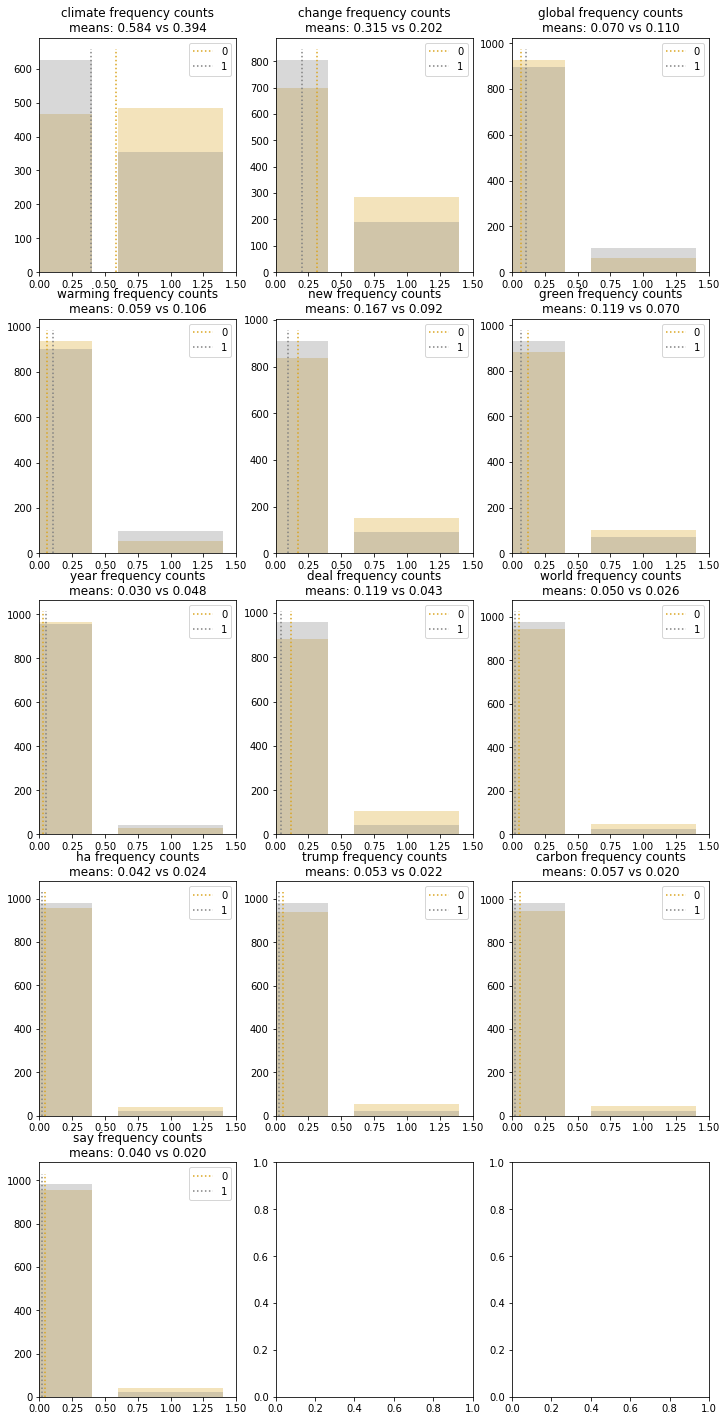

In [94]:
#Calling the function:
plot_cvec_dist(words_overlap_not_same_freq, term_df)

#### Looking at words that are vectorized using TF-IDF (term frequency — inverse data frequency) instead of counts (frequency in each subreddit)

Remember definition of TF-IDF:

$$\text{Term Frequency}\cdot\text{Inverse Document Frequency}$$

$$\text{Term Frequency} = \text{% times a word appears in a document}$$

$$\text{Inverse Document Frequency} = (\text{# documents that contain word})^{-1}$$

Source: Sam Stack helped with this during an NLP session.

In [95]:
#Importing TfidfVectorizer library
from sklearn.feature_extraction.text import TfidfVectorizer

In [96]:
#Instantiating TfidfVectorizer with English stop words removed and narrowing down focus to looking at 
#terms that have a document frequency strictly higher than 3 but also ensuring these words are
#not in 100% of post titles 
tfidf = TfidfVectorizer(stop_words='english', min_df=3, max_df = 1.0)

In [97]:
#Gerenating matrix of TfidfVectorized post titles (note that the preprocessed titles are used)
term_mat_t = tfidf.fit_transform(df['title_preprocessed']) 

#Organizing the TfidfVectorized post titles into a dataframe
term_tfidf = pd.DataFrame(term_mat_t.toarray(), 
                          columns=tfidf.get_feature_names())

In [98]:
#Inspecting shape of term_tfidf
term_tfidf.shape

(1997, 1313)

In [99]:
#Inspecting head of term_tfidf
term_tfidf.head()

,000,10,100,11,12,13,15,16,17,1975,20,200,2000,2007,2014,2016,2018,2019,2020,2025,2030,2050,2080,22,24,25,26,28,30,35,40,50,57,58,5c,60,80,97,99,abandon,able,academic,accept,access,accord,according,account,accurate,accused,acre,act,acting,action,activism,activist,activity,actual,actually,ad,adam,adaptable,address,adjustment,administration,admiral,admit,admits,adult,advice,advocate,affect,affecting,africa,age,agency,agenda,ago,agree,agriculture,agw,ahead,aim,air,airline,al,alarm,alarmism,alarmist,alaska,alexandria,alternative,ama,ambitious,america,american,amp,analysis,andrew,announces,annual,answer,antarctic,antarctica,anthropogenic,anti,anxiety,aoc,ap,apocalypse,apple,approach,arctic,area,argument,arizona,armchair,arrested,art,article,ask,assessment,astrophysicist,atlantic,atmosphere,atmospheric,attack,attend,audio,australia,australian,author,authority,available,average,aviation,away,baby,backed,backing,backlash,bad,ban,bank,bankruptcy,banned,banning,based,battery,battle,bbc,bear,beat,began,begun,belief,believe,benefit,bernie,best,beto,better,bias,big,bigger,biggest,billion,biodiversity,bit,blame,blamed,blast,block,blog,blow,board,body,bold,bomb,book,border,break,breaking,brilliant,bring,broecker,brown,brussels,brutal,budget,build,building,built,bullshit,burger,burn,burning,business,california,calling,came,campaign,canada,canadian,candidate,cap,capitalism,capture,car,carbon,carlson,case,cash,cast,catastrophe,catastrophic,catch,cause,caused,causing,censorship,center,central,century,challenge,challenging,chance,change,changing,chaos,chart,cheaper,check,chicago,chief,child,china,choice,citizen,city,civilisation,claim,claiming,class,clean,clear,climate,climatechange,climategate,climatologist,cloud,co2,coal,coalition,coast,cold,colder,coldest,collapse,college,colorado,columbia,columnist,combat,come,coming,comment,committee,common,communist,community,company,compared,comparison,completely,complex,concentration,concerned,concrete,condition,conference,conflict,congress,consensus,consequence,conservative,conspiracy,consumer,consumption,content,context,continue,contribute,control,conversation,cool,cooling,coral,core,corporate,corporation,correct,corruption,cortez,cosmic,cost,counter,country,course,court,cover,cow,craft,crazy,create,creating,crisis,critic,criticizing,crop,culprit,cult,current,curriculum,curry,cut,cutting,cycle,cyclone,dangerous,danish,dark,data,david,day,deal,death,debate,debunk,debunking,debunks,decade,declare,decline,deep,degree,delingpole,demand,democracy,democrat,democratic,...,reality,really,reason,rebellion,received,recent,recently,record,recorded,recovery,recycling,reduce,reducing,reduction,reef,reforestation,refugee,regarding,region,regulation,reject,related,release,reliable,religion,rely,remember,reminder,renewable,renewables,rep,replace,report,representative,republican,requires,research,researcher,resident,resolution,resource,response,responsible,rest,result,resulting,reveal,reveals,review,revolution,rich,ridd,right,rip,rise,rising,risk,river,role,roll,rourke,roy,rule,run,running,rural,safe,safety,said,sander,santer,satellite,save,saving,say,saying,scale,scam,scare,scary,scenario,school,schoolchildren,schoolkids,schumer,science,scientific,scientifically,scientist,scott,scrutiny,sea,second,security,seed,seeing,seen,senate,senator,sending,sense,sensitivity,series,seriously,service,set,seven,share,shell,shift,shifting,shock,short,showing,shrink,shrinking,shut,sigma,sign,significant,significantly,single,sink,skeptic,skepticism,ski,skip,sky,slam,slow,small,smart,snow,snowfall,snowpack,social,socialism,socialist,soil,solar,solution,solve,sorry,source,south,space,speak,specie,speech,spencer,spending,spent,standard,start,state,statement,stay,step,stick,stock,stop,stopfossilfuels,storm,story,street,strength,strike,striker,striking,strip,strong,student,study,stupid,sub,suffering,suggest,suggests,summer,summit,sun,sunspot,supply,support,supporting,surface,survey,survival,survive,sustainable,suzuki,sweeping,switzerland,ta

In [100]:
# Getting tfidf max, mean and sum for each column in term_tfidf and placing in col_summary dictionary 
col_summary = {col: [term_tfidf[col].max(),
                 term_tfidf[col].mean(),
                 term_tfidf[col].sum()] for col in term_tfidf.columns}
#for every word, getting max value, mean value, and sum

In [101]:
#Organizing col_summary into dataframe
tf_df = pd.DataFrame(col_summary, index = ['max','mean','sum']).T

#Inspecting head of tf_df:
tf_df.head()

,max,mean,sum
000,0.517248,0.002539,5.070945
10,0.550083,0.002439,4.870909
100,0.650255,0.003149,6.289201
11,0.620757,0.001774,3.543570
12,0.516794,0.001818,3.631250


In [102]:
#Looking at the 10 terms with the highest max tf-idf values:
tf_df.sort_values(by = 'max', ascending = False).head(10)

,max,mean,sum
little,1.0,0.002198,4.388543
thing,1.0,0.005146,10.277498
explain,1.0,0.001511,3.018242
let,1.0,0.001214,2.424007
data,1.0,0.005249,10.481684
truth,1.0,0.004849,9.682828
science,1.0,0.016367,32.685111
global,1.0,0.022624,45.179938
snow,1.0,0.004275,8.537339
march,1.0,0.003325,6.639682


A value of 1 means the word is very relevant to that post (not common in other posts).  It's interesting that the tf-idf can be affected by the length of the post title.  If the post title is longer, it reduces the tf-idf for words in that title (lower term frequency in that document makes the tf-idf lower).

The words little, thing, explain, let, data, truth, science, global, snow, and march appear to be very relevant to particular posts in either the r/climate or r/climateskeptics subreddits.

#### Sentiment Analysis by Class

In [103]:
#Importing SentimentIntensityAnalyzer and nltk libraries:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

#Instantiating SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [104]:
#Initiating dicts dictionary
dicts = []

#Generating dictionary of sentiment scores for each subreddit post title
for title in df['title_preprocessed']:
    #Finding polarity_score which tells us how positive or negatie a string is 
    scores = sia.polarity_scores(title) 
    #Adding post titles to the dictionary (for reference)
    scores['post_title_text'] = title
    #Appending each score to the dicts dictionary on each loop
    dicts.append(scores)

In [105]:
#Organizing sentiment scores into pandas dataframe:
df_sentiment = pd.DataFrame(dicts)
#Adding target class info to each row:
df_sentiment['our_target'] = target
#Inspecting the head of the df:
df_sentiment.head()

,compound,neg,neu,pos,post_title_text,our_target
0,0.4019,0.104,0.669,0.227,anomalous stabilisation ch concentration 2000 ...,0
1,0.2732,0.000,0.826,0.174,global carbon emission hit record high 2018 in...,0
2,0.0000,0.000,1.000,0.000,u judge scrap trump order opening arctic atlan...,0
3,-0.2023,0.283,0.542,0.175,ocasio cortez slam critic would wait climate a...,0
4,0.4939,0.000,0.238,0.762,save climate,0


In [106]:
df_sentiment.groupby(by='our_target').mean()

,compound,neg,neu,pos
our_target,,,,
0,-0.011927,0.128767,0.745072,0.125150
1,-0.062961,0.145060,0.744445,0.110502


It looks like global climate change skeptic post titles are slightly more negative, less neutral, and less positive than believer posts.  The difference in sentiment was smaller than expected.

#### Looking at how often words used as a noun, adjective, verb, or interjection in subreddit post titles

In [107]:
#Importing libraries needed:
import nltk
from nltk.corpus import brown

In the cells below, the top 50 words for each class (0:r/climate and 1: r/climateskeptics post titles) and what parts of speech they are will be inspected. It will be interesting to see if there are difference between classes.  For example, it will be interesting to see if more nouns, verbs, or adjectives appear more often in one class vs. the other.

In [108]:
#Finding the top 50 most used terms for each class and saving them to believers_pop and skeptics_pop:
believers_pop = list(term_df.groupby('our_target').sum().T.sort_values(0, ascending = False).head(50).index)
skeptics_pop = list(term_df.groupby('our_target').sum().T.sort_values(1, ascending = False).head(50).index)

In [109]:
#Saving the top 50 most used terms in each class into a set to prepare for the following cell:
#(note that duplicate values are removed)
pop = set(believers_pop + skeptics_pop)

In [110]:
#Note that this cell will take 5-8 min to run:

#Initiating pop_spe dictionary:
pop_spe = {}

for word in pop:
    #Printing words that are inspected to ensure the code is running properly:
    print(word)
    
    try:
        #If the word is found in brown.tagged_words, its part of speech is found and saved as 
        #the part of speech value for the word key in the dictionary 
        spe = nltk.FreqDist(t for w, t in brown.tagged_words() if w.lower() == word ).max()
        pop_spe[word] = spe
    except:
        # In the event the word doesn't appear, make it a Proper noun
        pop_spe[word] = 'NN'
        

scientific
carbon
ice
sea
year
new
energy
temperature
wind
good
support
denial
deal
study
amp
gas
record
co2
future
planet
strike
tax
human
time
california
want
like
student
plan
level
fuel
global
snow
weather
fossil
crisis
world
scientist
earth
warming
science
ha
need
country
school
policy
claim
rise
say
solar
change
news
oil
arctic
people
state
climate
cold
trump
alarmist
data
skeptic
medium
make
action
coal
green
emission
wa
delingpole


In [111]:
#Saving the dictionary values in a set
set(pop_spe.values())

{'CS', 'JJ', 'NN', 'NNS', 'NP', 'UH', 'VB', 'VBG'}

In [112]:
#Inspecting meanings of abbreviated parts of speech:
nltk.download('tagsets')
nltk.help.brown_tagset()
nltk.help.upenn_tagset()

(: opening parenthesis
    (
): closing parenthesis
    )
*: negator
    not n't
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ? ; ! :
:: colon
    :
ABL: determiner/pronoun, pre-qualifier
    quite such rather
ABN: determiner/pronoun, pre-quantifier
    all half many nary
ABX: determiner/pronoun, double conjunction or pre-quantifier
    both
AP: determiner/pronoun, post-determiner
    many other next more last former little several enough most least only
    very few fewer past same Last latter less single plenty 'nough lesser
    certain various manye next-to-last particular final previous present
    nuf
AP$: determiner/pronoun, post-determiner, genitive
    other's
AP+AP: determiner/pronoun, post-determiner, hyphenated pair
    many-much
AT: article
    the an no a every th' ever' ye
BE: verb 'to be', infinitive or imperative
    be
BED: verb 'to be', past tense, 2nd person singular or all persons plural
    were
BED*: verb 'to be', past tense, 2nd person singular or 

[nltk_data] Downloading package tagsets to /Users/julia/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [113]:
verb = ['CS','DOZ','VB','VBD','VBG']
noun = ['NN','NN-TL','NNS','NP','NR']
adje = ['RB','JJ','JJT']
interjection = ['UH']

In [114]:
verbs = [key for key, value in pop_spe.items() if value in verb]
nouns = [key for key, value in pop_spe.items() if value in noun]
adjec = [key for key, value in pop_spe.items() if value in adje]
interjections = [key for key, value in pop_spe.items() if value in interjection]

In [115]:
type_sum = pd.DataFrame(None)
type_sum['verbs'] = term_df.groupby('our_target')[verbs].sum().T.sum()
type_sum['nouns'] = term_df.groupby('our_target')[nouns].sum().T.sum()
type_sum['adjec'] = term_df.groupby('our_target')[adjec].sum().T.sum()
type_sum['interjection'] = term_df.groupby('our_target')[interjections].sum().T.sum()
type_sum['total_words_parts_speech'] = type_sum['verbs'] + type_sum['nouns'] + type_sum['adjec'] +  type_sum['interjection'] 

type_sum.index = ['Believers','Skeptics']
type_sum

,verbs,nouns,adjec,interjection,total_words_parts_speech
Believers,262,2161,396,42,2861
Skeptics,196,1545,393,24,2158


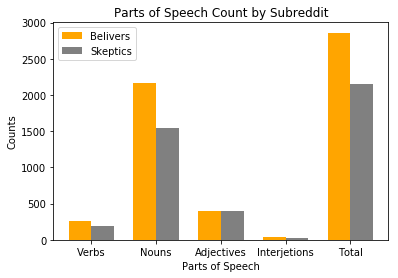

In [116]:
#Visualizing results above with bar chart:
N=5
width = 0.35
ind = np.arange(N) 
p1 = plt.bar(ind, type_sum.loc['Believers'], width, label = 'Believers', color='orange')
p2 = plt.bar(ind+width, type_sum.loc['Skeptics'], width, label = 'Skeptics', color = 'grey')
plt.xticks(ind + width / 2, ('Verbs', 'Nouns', 'Adjectives', 'Interjetions', 'Total'))
plt.xlabel('Parts of Speech')
plt.ylabel('Counts')
plt.title('Parts of Speech Count by Subreddit')
plt.legend((p1[0], p2[0]), ('Belivers', 'Skeptics'))

plt.show()

#Source:
#http://benalexkeen.com/bar-charts-in-matplotlib/

It's interesting that there are more verbs, nouns, interjections, and total words with easily identified parts of speech in the r/climate posts than the r/climateskeptics post titles.  Both subreddits have similar numbers of adjectives.

#### Train-Test-Splitting Data

Checking classes are pretty balanced:

In [117]:
df.shape

(1997, 9)

In [118]:
df['skeptic'].value_counts()

1    1002
0     995
Name: skeptic, dtype: int64

In [119]:
df['skeptic'].value_counts(normalize=True)

1    0.501753
0    0.498247
Name: skeptic, dtype: float64

In [120]:
#Creating train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['title_preprocessed']], #this is X (features df)
                                                    df['skeptic'],              #this is y (target series)
                                                    test_size = 0.25,
                                                    train_size = 0.75,
                                                    shuffle = True,
                                                    stratify = df['skeptic'],
                                                    random_state = 42)

In [121]:
X_train.shape

(1497, 1)

In [122]:
X_test.shape

(500, 1)

Checking the data was shuffled during train-test-split to maintain similar proportion of 1 class and 0 class in train and test sets: 

In [123]:
df['skeptic'].mean()

0.5017526289434151

In [124]:
y_train.mean()

0.5016700066800267

In [125]:
y_test.mean()

0.502

It appears that the test and train set have similar ratios of 1's to 0's to the original target dataset (approx. 50.2% of the data are 1's, and the rest are 0's).  It would be interesting to see if different random states would affect the shuffling of the data and the test and train data sets' ratios of 1's to 0's.

#### Naive Bayes Model on Subreddit Post Titles that are CountVectorized (English Stop Words Removed)

In [126]:
#Instantiating CountVectorizer:
cvec = CountVectorizer(stop_words='english',
                       min_df=5,    #at least 5 occurrences of the word needed to be placed in word df
                       max_df=0.99) #if a word occurs in over 99% of observations, it will not be included
                                    #in analysis (this is percent of observations word is allowed in)

#note: did not limit max_features (can see below that there are 507 words that are CountVectorized,
#and this seems like a reasonable number of features to inspect)

In [127]:
#CountVectorizing the data (counting number of each word in each observation (not including the stop words)):
#(fitting/training vectorizer using training data and using it to transform the training data and the testing 
#data)
#(being careful to use the trained vectorizer to transform the X_test set without refitting the vectorizer)
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['title_preprocessed']).todense(),
                            columns = cvec.get_feature_names())
X_test_cvec = pd.DataFrame(cvec.transform(X_test['title_preprocessed']).todense(),
                           columns = cvec.get_feature_names())

#Sources:
#Matt Brems helped with this during a Naive Bayes session.
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.tolist.html

In [128]:
X_train_cvec.shape

(1497, 507)

In [129]:
X_test_cvec.shape

(500, 507)

In [130]:
X_train_cvec.head()

,000,10,100,11,12,15,20,200,2016,2018,2019,2020,2050,25,30,35,40,50,act,action,activism,activist,actual,actually,affect,age,agenda,ago,agree,air,al,alarmism,alarmist,alexandria,ambitious,america,american,amp,analysis,answer,antarctica,anti,aoc,apocalypse,approach,arctic,area,argument,article,atmosphere,atmospheric,australia,australian,average,away,bad,bank,bankruptcy,bear,believe,bernie,best,better,big,biggest,billion,blame,block,blog,book,break,bring,built,burning,california,campaign,canada,canadian,capture,car,carbon,case,catastrophe,cause,caused,challenge,chance,change,changing,child,china,citizen,city,claim,clean,climate,cloud,co2,coal,cold,coldest,come,coming,comment,committee,company,completely,condition,consensus,consumption,conversation,cooling,coral,corporate,cortez,cost,country,court,create,crisis,cut,dangerous,data,david,day,deal,death,debate,debunking,decade,decline,deep,degree,delingpole,demand,democrat,denial,denier,despite,disaster,disease,doe,donald,doubt,dr,drilling,drought,dutch,earth,economic,effect,effort,electric,electricity,emergency,emission,end,energy,environment,environmental,epa,europe,event,evidence,expected,expert,extreme,face,fact,failing,failure,fake,far,farm,faster,fear,february,federal,feinstein,fight,fighting,fish,flood,flooding,focus,food,force,forest,fossil,fraud,free,fuel,funding,future,gas,general,generation,geoengineering,glacier,global,goal,going,gold,good,google,gop,gore,government,graph,great,green,greenhouse,greenland,greenpeace,greta,group,growing,growth,guide,ha,half,head,hearing,heat,heavy,hell,help,high,historical,history,hit,hoax,hockey,home,hope,hot,house,human,humanity,hysteria,ice,idea,impact,important,including,increase,increased,increasing,industry,infrastructure,inslee,instead,interview,ipcc,island,issue,jay,job,judge,key,kid,know,land,large,law,lawsuit,le,lead,left,let,letter,level,life,light,like,likely,line,link,little,live,lobbying,long,look,looking,loss,low,major,make,making,man,mann,map,march,marine,mayor,mcconnell,mean,medium,meet,melting,methane,michael,midwest,million,mind,minimum,missing,model,money,month,moore,movement,myth,narrative,nasa,national,natural,nature,need,new,news,noaa,non,north,northern,nuclear,number,ocasio,ocean,office,official,oil,old,open,outside,page,panel,paper,paris,party,past,patrick,people,pg,picture,pipeline,place,plan,planet,plant,pledge,point,polar,policy,political,politics,pollution,poor,post,power,prediction,president,presidential,price,pricing,private,problem,project,protest,public,push,question,race,radical,raise,read,real,really,reason,record,reduce,reducing,reduction,reef,renewable,renewables,report,republican,research,researcher,resolution,result,right,rise,rising,risk,rule,running,said,save,say,scam,scare,school,science,scientific,scientist,sea,security,senate,senator,set,shifting,short,skeptic,slow,snow,solar,solution,solve,source,south,specie,standard,start,state,stick,stop,storm,strike,student,study,summer,support,surface,survive,tackle,taking,talk,talking,target,tax,tell,temp,temperature,tesla,test,theory,thing,think,thought,thousand,threat,thunberg,time,today,town,tree,trillion,trump,truth,try,trying,turbine,turn,tweet,uk,understand,uninhabitable,university,use,used,using,video,vote,wa,wallace,want,war,warm,warmer,warming,warn,warning,warns,washington,water,wave,way,weather,week,west,white,wildfire,wind,winter,wonder,work,world,worldwide,worried,wrong,year,york,young,youth,zero
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [131]:
X_train_cvec.describe() #note that the column values are integer counts (not only 0's and 1's!)

,000,10,100,11,12,15,20,200,2016,2018,2019,2020,2050,25,30,35,40,50,act,action,activism,activist,actual,actually,affect,age,agenda,ago,agree,air,al,alarmism,alarmist,alexandria,ambitious,america,american,amp,analysis,answer,antarctica,anti,aoc,apocalypse,approach,arctic,area,argument,article,atmosphere,atmospheric,australia,australian,average,away,bad,bank,bankruptcy,bear,believe,bernie,best,better,big,biggest,billion,blame,block,blog,book,break,bring,built,burning,california,campaign,canada,canadian,capture,car,carbon,case,catastrophe,cause,caused,challenge,chance,change,changing,child,china,citizen,city,claim,clean,climate,cloud,co2,coal,cold,coldest,come,coming,comment,committee,company,completely,condition,consensus,consumption,conversation,cooling,coral,corporate,cortez,cost,country,court,create,crisis,cut,dangerous,data,david,day,deal,death,debate,debunking,decade,decline,deep,degree,delingpole,demand,democrat,denial,denier,despite,disaster,disease,doe,donald,doubt,dr,drilling,drought,dutch,earth,economic,effect,effort,electric,electricity,emergency,emission,end,energy,environment,environmental,epa,europe,event,evidence,expected,expert,extreme,face,fact,failing,failure,fake,far,farm,faster,fear,february,federal,feinstein,fight,fighting,fish,flood,flooding,focus,food,force,forest,fossil,fraud,free,fuel,funding,future,gas,general,generation,geoengineering,glacier,global,goal,going,gold,good,google,gop,gore,government,graph,great,green,greenhouse,greenland,greenpeace,greta,group,growing,growth,guide,ha,half,head,hearing,heat,heavy,hell,help,high,historical,history,hit,hoax,hockey,home,hope,hot,house,human,humanity,hysteria,ice,idea,impact,important,including,increase,increased,increasing,industry,infrastructure,inslee,instead,interview,ipcc,island,issue,jay,job,judge,key,kid,know,land,large,law,lawsuit,le,lead,left,let,letter,level,life,light,like,likely,line,link,little,live,lobbying,long,look,looking,loss,low,major,make,making,man,mann,map,march,marine,mayor,mcconnell,mean,medium,meet,melting,methane,michael,midwest,million,mind,minimum,missing,model,money,month,moore,movement,myth,narrative,nasa,national,natural,nature,need,new,news,noaa,non,north,northern,nuclear,number,ocasio,ocean,office,official,oil,old,open,outside,page,panel,paper,paris,party,past,patrick,people,pg,picture,pipeline,place,plan,planet,plant,pledge,point,polar,policy,political,politics,pollution,poor,post,power,prediction,president,presidential,price,pricing,private,problem,project,protest,public,push,question,race,radical,raise,read,real,really,reason,record,reduce,reducing,reduction,reef,renewable,renewables,report,republican,research,researcher,resolution,result,right,rise,rising,risk,rule,running,said,save,say,scam,scare,school,science,scientific,scientist,sea,security,senate,senator,set,shifting,short,skeptic,slow,snow,solar,solution,solve,source,south,specie,standard,start,state,stick,stop,storm,strike,student,study,summer,support,surface,survive,tackle,taking,talk,talking,target,tax,tell,temp,temperature,tesla,test,theory,thing,think,thought,thousand,threat,thunberg,time,today,town,tree,trillion,trump,truth,try,trying,turbine,turn,tweet,uk,understand,uninhabitable,university,use,used,using,video,vote,wa,wallace,want,war,warm,warmer,warming,warn,warning,warns,washington,water,wave,way,weather,week,west,white,wildfire,wind,winter,wonder,work,world,worldwide,worried,wrong,year,york,young,youth,zero
count,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1

#### Fitting to Naive Bayes Model and Generating Predictions

In [132]:
# Importing Multinomial Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB

In [133]:
# Instantiating the Multinomial Naive Bayes Model 
nb = MultinomialNB()

#Fiting the Multinomial Naive Bayes Model 
nb_model = nb.fit(X_train_cvec, y_train)

#Generating predictions on test data:
predictions = nb_model.predict(X_test_cvec)

#Score: 
print('Cross-validation score:', cross_val_score(nb_model, X_train_cvec, y_train, cv=3).mean())
print('Train score:', nb.score(X_train_cvec, y_train))
print('Test score:', nb.score(X_test_cvec, y_test))

#Source: Matt Brems helped with this during a Naive Bayes session.

Cross-validation score: 0.6566283088264884
Train score: 0.7688710754843019
Test score: 0.676


In [134]:
#Baseline model accuracy:
y_train.value_counts()

1    751
0    746
Name: skeptic, dtype: int64

In [135]:
#Baseline model accuracy:
y_train.value_counts(normalize = True)

1    0.50167
0    0.49833
Name: skeptic, dtype: float64

The baseline model accuracy is the majority class percentage in the train dataset which is approx. 50.2% (and since the train-test-split was stratified, this is the same value for the original unsplit dataset).

It looks like the train score is much better than the test score and cross-validation score.  This means that the model is overfit to the training data (it suffers from high variance).

Note that scores represent model accuracy here since this is a classification model.

What could do at this point (to reduce the variance of the model and to improve the model overall):
- try to collect more data (not possible due to time constraints),
- try using fewer features by setting max_features to a smaller number when instantiating the CountVectorizer,
- try TF-IDF Vectorizer instead of CountVectorizer,
- try a non-default prior (but this will not be pursued since this requires subject-matter expertise)
- try a different model (perhaps also try regularization)

Scores (representing accuracy) when use Naive Bayes to model count vectorized preprocessed post titles:
Cross-validation score: approx. 0.657
Train score: approx. 0.769
Test score: 0.676

Baseline accuracy: approx. 0.502 (definitely surpassed the baseline accuracy)

Source: Matt Brems helped with this during a Naive Bayes session.

#### Logistic Regression Model on Post Titles that are CountVectorized (English Stop Words Removed)

In [136]:
#Instantiating LogisticRegression
logreg = LogisticRegression(solver = 'lbfgs', multi_class = 'auto')

#Fitting the LogisticRegression model:
logreg.fit(X_train_cvec, y_train)

#Generating predictions on test data:
predictions = logreg.predict(X_test_cvec)

#Score: 
print('Cross-validation score:', cross_val_score(logreg, X_train_cvec, y_train, cv=3).mean())
print('Train score:', logreg.score(X_train_cvec, y_train))
print('Test score:', logreg.score(X_test_cvec, y_test))

#Sources:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

Cross-validation score: 0.6766965685051495
Train score: 0.8410153640614563
Test score: 0.664


The logistic regression model created using preprocessed post titles that were CountVectorized with English stop words removed (and with no hyperparameter settings adjusted) has a great train score but a significantly lower test score and cross-validation score.  The train and cross-validation scores are better when using logistic regression than when using naive Bayes.  The test score is slightly worse.  It looks like the model is more overfit as well.

It seems that feature engineering would be a natural next step (for example, the max_features could be increased or decreased during CountVectorization).  In this case, latent semantic analysis will be used.  This can help with increasing understanding of groupings of words and topics within subreddits.

Logistic regression on count vectorized post titles:
Cross-validation score: approx. 0.677
Train score: approx. 0.841
Test score: 0.664

Scores (representing accuracy) when use Naive Bayes to model count vectorized preprocessed post titles:
Cross-validation score: approx. 0.657
Train score: approx. 0.769
Test score: 0.676

Baseline accuracy: approx. 0.502 (definitely surpassed the baseline accuracy)

#### Latent Semantic Analysis (LSA)

Note that Sam Stack helped with this during an NLP session.

In [137]:
#Instantiating TfidfVectorizer with English stop words removed and narrowing down focus to looking at 
#terms that have a document frequency strictly higher than 5 but also ensuring do not include words that are
#in 99%-100% of post titles 
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df = 0.99)



In [138]:
#TfidfVectorizing the data
term_mat = tfidf.fit_transform(df['title_preprocessed'])

In [139]:
len(tfidf.get_feature_names())

692

There are 692 words in the term matrix.  To save on computational space, pandas `SparseDataFrame` call will be used to optimize storage when most of the entires are 0.

In [140]:
#Creating dense version of the dataframe
term_df_dense = pd.DataFrame(term_mat.todense(), columns=tfidf.get_feature_names())

In [141]:
from sys import getsizeof

In [142]:
term_df_dense.head()

,000,10,100,11,12,15,17,20,200,2016,2018,2019,2020,2050,2080,25,30,35,40,50,58,60,academic,accept,access,according,act,action,activism,activist,activity,actual,actually,adam,address,administration,affect,age,agenda,ago,agree,air,al,alarmism,alarmist,alexandria,alternative,ambitious,america,american,amp,analysis,answer,antarctic,antarctica,anti,aoc,apocalypse,approach,arctic,area,argument,article,assessment,atlantic,atmosphere,atmospheric,australia,australian,author,average,away,bad,bank,bankruptcy,banned,bbc,bear,belief,believe,benefit,bernie,best,better,big,biggest,billion,blame,block,blog,bomb,book,break,bring,build,building,built,burning,business,california,calling,came,campaign,canada,canadian,capitalism,capture,car,carbon,case,cash,catastrophe,catastrophic,cause,caused,century,challenge,chance,change,changing,chaos,check,chief,child,china,citizen,city,claim,clean,clear,climate,climatologist,cloud,co2,coal,cold,colder,coldest,collapse,colorado,combat,come,coming,comment,committee,community,company,completely,complex,condition,congress,consensus,conservative,conspiracy,consumption,contribute,control,conversation,cool,cooling,coral,corporate,cortez,cost,country,court,create,crisis,cut,cyclone,dangerous,data,david,day,deal,death,debate,debunking,debunks,decade,decline,deep,degree,delingpole,demand,democrat,democratic,denial,denier,despite,destroying,developing,dioxide,disaster,discussion,disease,doe,donald,doubt,dr,drilling,driven,drop,drought,dutch,dying,earth,economic,effect,effort,electric,electricity,emergency,emission,end,ending,energy,entire,environment,environmental,epa,europe,european,event,evidence,expected,expert,explain,explains,explanation,expose,extinction,extreme,face,fact,failing,failure,fake,family,far,farm,faster,fear,february,federal,feel,feinstein,fight,fighting,finding,fish,fix,flood,flooding,focus,food,force,forest,fossil,founder,fox,fraud,free,friday,fuel,funding,future,gas,general,generation,geoengineering,german,germany,given,glacier,global,goal,going,gold,good,google,gop,gore,got,government,graph,great,green,greenhouse,greenland,greenpeace,greta,group,growing,growth,guide,guy,ha,half,happened,hawaii,head,health,hearing,heat,heatwave,heavy,hell,heller,help,high,higher,historical,history,hit,hoax,hockey,home,hope,hot,hottest,house,huge,human,humanity,hysteria,ice,idea,ignores,immediate,impact,important,including,increase,increased,increasing,industrial,industry,infrastructure,insane,inslee,inspired,instead,interview,ipcc,island,issue,jay,jet,job,john,join,joke,judge,justice,key,kid,kill,know,lake,land,large,latest,law,lawmaker,lawsuit,le,lead,leading,led,left,let,letter,level,liberal,lie,life,light,like,likely,line,link,list,little,live,lobbying,lobbyist,long,look,looking,losing,loss,low,magazine,major,make,making,man,mann,map,march,marine,massive,mayor,mcconnell,mean,measure,medium,meet,melt,melting,member,methane,metric,michael,midwest,mike,million,min,mind,minimum,minute,missing,mitch,model,modern,money,month,moore,movement,myth,narrative,nasa,nation,national,natural,nature,nearly,need,needed,negative,new,news,noaa,non,nonsense,north,northern,nuclear,number,observation,ocasio,ocean,office,official,oil,old,open,organization,outside,page,panel,panic,paper,paris,party,past,patrick,pay,people,percent,pg,physicist,pick,picture,pipeline,place,plan,planet,plant,pledge,podcast,point,polar,pole,policy,political,politician,politics,pollution,poor,population,post,power,prediction,president,presidential,prevent,price,pricing,private,problem,process,production,project,proof,proposal,protest,public,push,question,race,radical,rain,raise,rare,rate,read,real,reality,really,reason,recent,record,reduce,reducing,reduction,reef,refugee,related,renewable,renewables,report,representative,republican,research,researcher,resolution,result,reveals,review,right,rise,rising,risk,rule,running,safe,said,save,say,scale,scam,scare,scenario,school,science,scientific,scientist,scott,sea,security,seen,senate,senator,sense,seriously,set

In [143]:
getsizeof(term_df_dense)

11055496

In [144]:
#Creating sparse version of the dataframe
term_df = pd.SparseDataFrame(term_mat, columns=tfidf.get_feature_names())

In [145]:
term_df.head()
# seems this removed all 0 values and replaced with NaN

,000,10,100,11,12,15,17,20,200,2016,2018,2019,2020,2050,2080,25,30,35,40,50,58,60,academic,accept,access,according,act,action,activism,activist,activity,actual,actually,adam,address,administration,affect,age,agenda,ago,agree,air,al,alarmism,alarmist,alexandria,alternative,ambitious,america,american,amp,analysis,answer,antarctic,antarctica,anti,aoc,apocalypse,approach,arctic,area,argument,article,assessment,atlantic,atmosphere,atmospheric,australia,australian,author,average,away,bad,bank,bankruptcy,banned,bbc,bear,belief,believe,benefit,bernie,best,better,big,biggest,billion,blame,block,blog,bomb,book,break,bring,build,building,built,burning,business,california,calling,came,campaign,canada,canadian,capitalism,capture,car,carbon,case,cash,catastrophe,catastrophic,cause,caused,century,challenge,chance,change,changing,chaos,check,chief,child,china,citizen,city,claim,clean,clear,climate,climatologist,cloud,co2,coal,cold,colder,coldest,collapse,colorado,combat,come,coming,comment,committee,community,company,completely,complex,condition,congress,consensus,conservative,conspiracy,consumption,contribute,control,conversation,cool,cooling,coral,corporate,cortez,cost,country,court,create,crisis,cut,cyclone,dangerous,data,david,day,deal,death,debate,debunking,debunks,decade,decline,deep,degree,delingpole,demand,democrat,democratic,denial,denier,despite,destroying,developing,dioxide,disaster,discussion,disease,doe,donald,doubt,dr,drilling,driven,drop,drought,dutch,dying,earth,economic,effect,effort,electric,electricity,emergency,emission,end,ending,energy,entire,environment,environmental,epa,europe,european,event,evidence,expected,expert,explain,explains,explanation,expose,extinction,extreme,face,fact,failing,failure,fake,family,far,farm,faster,fear,february,federal,feel,feinstein,fight,fighting,finding,fish,fix,flood,flooding,focus,food,force,forest,fossil,founder,fox,fraud,free,friday,fuel,funding,future,gas,general,generation,geoengineering,german,germany,given,glacier,global,goal,going,gold,good,google,gop,gore,got,government,graph,great,green,greenhouse,greenland,greenpeace,greta,group,growing,growth,guide,guy,ha,half,happened,hawaii,head,health,hearing,heat,heatwave,heavy,hell,heller,help,high,higher,historical,history,hit,hoax,hockey,home,hope,hot,hottest,house,huge,human,humanity,hysteria,ice,idea,ignores,immediate,impact,important,including,increase,increased,increasing,industrial,industry,infrastructure,insane,inslee,inspired,instead,interview,ipcc,island,issue,jay,jet,job,john,join,joke,judge,justice,key,kid,kill,know,lake,land,large,latest,law,lawmaker,lawsuit,le,lead,leading,led,left,let,letter,level,liberal,lie,life,light,like,likely,line,link,list,little,live,lobbying,lobbyist,long,look,looking,losing,loss,low,magazine,major,make,making,man,mann,map,march,marine,massive,mayor,mcconnell,mean,measure,medium,meet,melt,melting,member,methane,metric,michael,midwest,mike,million,min,mind,minimum,minute,missing,mitch,model,modern,money,month,moore,movement,myth,narrative,nasa,nation,national,natural,nature,nearly,need,needed,negative,new,news,noaa,non,nonsense,north,northern,nuclear,number,observation,ocasio,ocean,office,official,oil,old,open,organization,outside,page,panel,panic,paper,paris,party,past,patrick,pay,people,percent,pg,physicist,pick,picture,pipeline,place,plan,planet,plant,pledge,podcast,point,polar,pole,policy,political,politician,politics,pollution,poor,population,post,power,prediction,president,presidential,prevent,price,pricing,private,problem,process,production,project,proof,proposal,protest,public,push,question,race,radical,rain,raise,rare,rate,read,real,reality,really,reason,recent,record,reduce,reducing,reduction,reef,refugee,related,renewable,renewables,report,representative,republican,research,researcher,resolution,result,reveals,review,right,rise,rising,risk,rule,running,safe,said,save,say,scale,scam,scare,scenario,school,science,scientific,scientist,scott,sea,security,seen,senate,senator,sense,seriously,set

In [146]:
getsizeof(term_df)

163496

In [147]:
(getsizeof(term_df_dense) - getsizeof(term_df)) / getsizeof(term_df_dense)

0.9852113374198679

The sparse dataframe reduces the size of this object by approx. 98.5%, so it will be used.

In [148]:
#Filling null values with 0's:
term_df.fillna(0, inplace=True)

#Checking if this changed the size of term_df:
getsizeof(term_df)

163496

Note that the size of the df did not change after filling null values with 0's.

In [149]:
term_df.head()

,000,10,100,11,12,15,17,20,200,2016,2018,2019,2020,2050,2080,25,30,35,40,50,58,60,academic,accept,access,according,act,action,activism,activist,activity,actual,actually,adam,address,administration,affect,age,agenda,ago,agree,air,al,alarmism,alarmist,alexandria,alternative,ambitious,america,american,amp,analysis,answer,antarctic,antarctica,anti,aoc,apocalypse,approach,arctic,area,argument,article,assessment,atlantic,atmosphere,atmospheric,australia,australian,author,average,away,bad,bank,bankruptcy,banned,bbc,bear,belief,believe,benefit,bernie,best,better,big,biggest,billion,blame,block,blog,bomb,book,break,bring,build,building,built,burning,business,california,calling,came,campaign,canada,canadian,capitalism,capture,car,carbon,case,cash,catastrophe,catastrophic,cause,caused,century,challenge,chance,change,changing,chaos,check,chief,child,china,citizen,city,claim,clean,clear,climate,climatologist,cloud,co2,coal,cold,colder,coldest,collapse,colorado,combat,come,coming,comment,committee,community,company,completely,complex,condition,congress,consensus,conservative,conspiracy,consumption,contribute,control,conversation,cool,cooling,coral,corporate,cortez,cost,country,court,create,crisis,cut,cyclone,dangerous,data,david,day,deal,death,debate,debunking,debunks,decade,decline,deep,degree,delingpole,demand,democrat,democratic,denial,denier,despite,destroying,developing,dioxide,disaster,discussion,disease,doe,donald,doubt,dr,drilling,driven,drop,drought,dutch,dying,earth,economic,effect,effort,electric,electricity,emergency,emission,end,ending,energy,entire,environment,environmental,epa,europe,european,event,evidence,expected,expert,explain,explains,explanation,expose,extinction,extreme,face,fact,failing,failure,fake,family,far,farm,faster,fear,february,federal,feel,feinstein,fight,fighting,finding,fish,fix,flood,flooding,focus,food,force,forest,fossil,founder,fox,fraud,free,friday,fuel,funding,future,gas,general,generation,geoengineering,german,germany,given,glacier,global,goal,going,gold,good,google,gop,gore,got,government,graph,great,green,greenhouse,greenland,greenpeace,greta,group,growing,growth,guide,guy,ha,half,happened,hawaii,head,health,hearing,heat,heatwave,heavy,hell,heller,help,high,higher,historical,history,hit,hoax,hockey,home,hope,hot,hottest,house,huge,human,humanity,hysteria,ice,idea,ignores,immediate,impact,important,including,increase,increased,increasing,industrial,industry,infrastructure,insane,inslee,inspired,instead,interview,ipcc,island,issue,jay,jet,job,john,join,joke,judge,justice,key,kid,kill,know,lake,land,large,latest,law,lawmaker,lawsuit,le,lead,leading,led,left,let,letter,level,liberal,lie,life,light,like,likely,line,link,list,little,live,lobbying,lobbyist,long,look,looking,losing,loss,low,magazine,major,make,making,man,mann,map,march,marine,massive,mayor,mcconnell,mean,measure,medium,meet,melt,melting,member,methane,metric,michael,midwest,mike,million,min,mind,minimum,minute,missing,mitch,model,modern,money,month,moore,movement,myth,narrative,nasa,nation,national,natural,nature,nearly,need,needed,negative,new,news,noaa,non,nonsense,north,northern,nuclear,number,observation,ocasio,ocean,office,official,oil,old,open,organization,outside,page,panel,panic,paper,paris,party,past,patrick,pay,people,percent,pg,physicist,pick,picture,pipeline,place,plan,planet,plant,pledge,podcast,point,polar,pole,policy,political,politician,politics,pollution,poor,population,post,power,prediction,president,presidential,prevent,price,pricing,private,problem,process,production,project,proof,proposal,protest,public,push,question,race,radical,rain,raise,rare,rate,read,real,reality,really,reason,recent,record,reduce,reducing,reduction,reef,refugee,related,renewable,renewables,report,representative,republican,research,researcher,resolution,result,reveals,review,right,rise,rising,risk,rule,running,safe,said,save,say,scale,scam,scare,scenario,school,science,scientific,scientist,scott,sea,security,seen,senate,senator,sense,seriously,set

In [150]:
term_df.shape

(1997, 692)

##### Train-Test-Splitting the TF-IDF Data

In [151]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(term_df,         #this is X (features df)
                                                    df['skeptic'],   #this is y (target series)
                                                    test_size = 0.25,
                                                    train_size = 0.75,
                                                    shuffle = True,
                                                    stratify = df['skeptic'],
                                                    random_state = 42)

##### Computing SVD (Singular Value Decomposition)

In [152]:
#Importing TruncatedSVD library
from sklearn.decomposition import TruncatedSVD

In [153]:
#Instantiating the SVD 
#n_components only affects how the data is returned
#(changing the number of componenets you want broken down to should not affect how values appear in the topics)
SVD = TruncatedSVD(n_components=300)

#Fitting and transforming training data to create svd matrix for training data
svd_matrix_train = SVD.fit_transform(X_train)
#Transforming testing data to create svd matrix for testing data
svd_matrix_test = SVD.transform(X_test)

In [154]:
svd_matrix_train.shape

(1497, 300)

In [155]:
svd_matrix_test.shape

(500, 300)

In [156]:
term_df.shape

(1997, 692)

In [157]:
SVD.components_.shape

(300, 692)

There are 300 components from the 692 words.  Columns are now vector combinations, and rows represent how the word contributes to the direction of the vector (multidimensional direction)

In [158]:
#Organizing the data
comp_df = pd.DataFrame(SVD.components_.T, index = term_df.columns)
comp_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
000,0.008694,-0.001378,0.009922,-0.004992,0.016146,0.000048,-0.005647,0.015998,0.000415,-0.005679,0.003292,-0.002229,0.003754,-0.000499,-0.004026,0.016167,-0.005303,-0.005338,0.014800,-0.004085,0.012472,0.027274,0.017926,0.003616,-0.016914,-0.001362,-0.009322,-0.001156,0.009704,0.000408,0.007407,0.000465,0.006823,0.000808,-0.000188,-0.004164,-0.000967,0.001691,0.006288,-0.006780,-0.019324,-0.003456,0.000087,0.001489,-0.029413,-0.025954,0.017599,0.019065,-0.013445,0.015849,-0.035894,-0.004485,0.006839,-0.043721,-0.009111,-0.026021,-0.034963,0.012973,0.006464,-0.010928,-0.051039,0.017562,0.048628,-0.030116,0.008902,-0.041560,0.005162,0.007110,-0.001534,0.028268,0.036966,-0.019849,0.018468,-0.007080,-0.001772,0.046352,0.048312,0.022449,0.009250,-0.027351,0.038866,0.020308,0.039069,-0.031587,-0.005901,-0.046547,0.024038,0.023837,-0.002220,-0.065643,-0.064472,-0.094328,-0.090935,-0.000260,-0.029242,-0.032768,0.095422,-0.059955,0.002039,-0.005779,0.055743,-0.004497,0.060045,0.028137,0.045087,0.030448,0.031024,-0.062236,0.004309,0.006645,-0.028338,0.053264,-0.045880,-0.007456,0.071215,-0.035570,-0.014329,0.033452,0.002416,-0.004018,0.057099,0.054069,0.135360,0.101533,-0.030868,-0.038541,-0.039939,-0.028963,0.026779,0.045723,0.071412,-0.039257,0.018967,-0.034988,-0.022510,0.016244,-0.062333,-0.024515,0.003283,-0.095698,-0.074301,0.014195,-0.109722,-0.028174,0.114671,0.009966,-0.077405,-0.044248,0.008960,0.061553,0.046574,0.020556,0.010022,-0.001169,0.012480,-0.044690,-0.004844,0.004941,-0.121895,-0.042379,0.068769,0.053747,-0.001504,0.013110,0.050916,-0.052935,-0.139701,0.016588,-0.003640,-0.011664,0.006886,-0.038339,-0.014922,0.072894,0.064243,0.017348,-0.032141,-0.044372,0.015809,0.049823,0.018984,0.044911,0.050601,-0.069410,0.003423,0.045264,-0.020899,0.021782,0.063656,-0.002624,0.009353,0.016527,-0.001560,-0.046878,0.032411,0.033512,-0.003452,-0.061182,0.034728,0.012866,0.008002,0.023565,0.019557,0.011563,-0.038617,-0.011259,-0.011940,0.039701,0.029061,0.047751,-0.072659,-0.061483,0.054141,-0.002229,-0.014094,0.051579,0.041265,0.058786,0.047077,0.069879,0.067612,-0.039498,0.011893,-0.026138,-0.028669,0.038257,0.027035,0.005892,0.029747,-0.062106,-0.003739,-0.037457,0.003472,-0.056969,0.090666,0.014222,0.025614,-0.004837,0.008485,-0.131148,-0.030729,-0.036950,0.071609,0.047915,-0.053095,0.020325,-0.076198,-0.023136,0.016280,0.027294,0.030634,-0.028256,-0.045921,-0.025613,0.003231,0.022812,-0.012499,0.045657,0.019284,-0.006200,0.095510,-0.020881,0.026890,0.010522,-0.016663,0.063714,-0.072272,-0.014770,0.003020,-0.074878,0.015941,-0.027249,0.003601,0.004926,0.058763,-0.046621,0.021648,-0.065198,0.041229,-0.048800,0.075181,-0.026431,0.045805,0.006995,0.034879,0.016107,-0.034703,0.039428,-0.055215,-0.019692,-0.000885,0.013243,-0.095321,0.004247,-0.024142,0.034246,0.039511,-0.027160,0.036014,-0.042269
10,0.004668,-0.000859,0.011773,-0.003931,0.017138,-0.016113,0.0117

In [159]:
#Looking at terms that contribute most to group 0 (PC1):
comp_df.sort_values(by=0, ascending = False).head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
climate,0.689844,-0.187182,-0.075087,0.056144,0.051732,0.235025,0.204286,-0.239435,0.145425,-0.144045,-0.185911,0.106513,-0.143693,0.068673,0.011896,-0.192353,0.075194,-0.135030,-0.069111,0.137280,-0.004145,0.011384,-0.002527,-0.064564,-0.053060,-0.037478,0.031235,0.009665,-0.062186,-0.025545,-0.067326,-0.039951,-0.025254,0.005502,-0.003322,-0.035481,-0.069903,-0.003766,-0.011291,0.016283,0.053617,0.020388,-0.010884,0.000161,0.009557,-0.060139,0.065670,0.038739,-0.051108,-0.003805,-0.032240,0.018748,0.006092,0.004858,0.005778,0.021835,-0.006069,-0.000648,-0.001740,-0.033187,0.017940,-0.008242,-0.001709,0.006616,-0.038484,0.037286,0.002726,0.025806,0.046170,0.005139,0.008172,0.020580,-0.037299,-0.012177,0.012964,-0.005795,-0.020403,0.004977,-0.007667,-0.014474,-0.029382,0.026017,0.018234,-0.029107,-0.026381,-0.007700,0.021626,0.008878,0.027940,-0.019927,-0.004003,0.020296,-0.016984,-0.001161,0.011571,-0.006193,0.001140,-0.031378,0.013817,-0.022624,-0.017412,0.000121,-0.038626,-0.016278,0.013516,-0.027381,0.005475,0.000654,0.018040,-0.005816,0.021032,-0.027366,0.023290,-0.016226,-0.027108,0.027960,0.024181,-0.000306,0.018220,0.023158,0.000694,0.014947,-0.009732,-0.018055,-0.003624,-0.003784,0.009034,0.008867,-0.001252,0.026864,0.002130,0.010227,0.026477,-0.012845,0.008649,0.021365,0.020253,-0.023161,-0.007465,-0.012514,-0.001387,0.011182,-0.011821,0.009401,0.025486,0.016384,0.012163,-0.012684,0.018864,0.003327,0.008521,-0.013554,0.029011,0.007558,-0.011676,0.009600,0.005539,0.020987,-0.025828,-0.009125,0.019746,-0.013031,0.026793,-0.011705,-0.012988,0.001564,-0.002795,0.001489,0.002908,0.016002,-0.013330,-0.000078,0.006179,-0.001722,-0.018210,-0.011989,0.011566,0.004439,-0.013020,-0.008058,-0.013235,-0.030344,-0.024270,-0.009719,0.011858,-0.013320,-0.031646,0.001038,0.003488,0.002217,-0.033517,-0.006276,-0.004132,0.038221,-0.003457,-0.013167,0.008960,-0.011818,-0.008642,-0.016715,-0.018846,-0.013061,-0.030616,0.004465,-0.006369,-0.036224,0.001197,0.000480,-0.002181,-0.006500,0.002875,-0.002217,0.006670,-0.001592,-0.013102,0.006300,-0.016387,-0.003479,0.003481,-0.006021,-0.016805,0.013173,-0.024964,-0.007314,0.011118,0.017628,0.003123,-0.003558,-0.000066,-0.028269,0.003460,0.001532,0.015636,0.012718,-0.002959,-0.006675,-0.001816,0.018183,0.012633,-0.010149,-0.005337,0.020400,0.021501,0.013073,-0.030614,0.002533,0.000311,-0.013161,-0.017813,-0.016858,-0.008140,0.013537,-0.018350,-0.010585,-0.007388,-0.005093,0.004810,-0.013276,0.001834,0.004087,-0.001488,0.022809,-0.026232,0.018007,0.020327,0.010799,-0.022904,0.001035,-0.018549,-0.004326,0.015859,-0.006305,0.007934,-0.006471,0.021442,-0.007972,0.001851,0.024169,0.008035,0.000084,0.011882,0.005756,0.002198,-0.013044,-0.014218,0.017627,-0.009623,-0.016762,-0.001571,0.008465,-0.008176,-0.002331,-0.002900,-0.014645,0.005568,0.005132,0.022696,-0.009705,-0.008770,0.017802
change,0.598830,-0.188532,-0.110344,-0.294915

Numbers are the principle components which are vectors that the mathematical process found have the most breadth and depth (they are combinations of words).
Looking at what words were given high weights for the combination for group 0 (PC1): "climate" then "change" and then "new" contribute most.

In [160]:
#Looking at terms that contribute most to group 1 (PC2):
comp_df.sort_values(by=1, ascending = False).head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
green,0.133411,0.585940,-0.048586,-0.010254,-0.023218,-0.056848,-0.018495,0.059948,0.144724,0.027389,0.091585,-0.005757,-0.009733,0.071601,0.059506,-0.037183,-0.106272,-0.029680,0.008014,0.044816,0.061252,-0.098217,0.031139,-0.004229,0.026448,-0.207264,0.114216,0.043581,-0.117036,-0.119561,0.065515,-0.144069,-0.029555,-0.003151,-0.068609,0.081440,-0.093104,0.049878,0.041492,0.154891,-0.032647,0.020800,-0.025796,-0.015356,-0.035592,-0.002257,0.050675,0.018955,-0.021701,-0.079882,-0.075986,-0.008206,0.076493,0.006127,-0.002154,0.067882,-0.067978,-0.008751,0.007084,-0.081377,-0.065809,0.009805,0.014783,-0.036042,0.025950,-0.080768,0.001377,0.024109,0.009080,0.031346,0.020261,0.076411,0.073661,0.029568,0.026692,0.037820,0.010523,0.039914,0.001929,-0.018803,-0.034228,-0.027936,-0.033520,0.012756,-0.025062,-0.020555,-0.040619,-0.025929,0.002663,0.020722,-0.005471,0.008043,0.034568,0.022526,0.002858,0.008704,0.013590,-0.102968,-0.008070,0.080954,0.016549,0.030368,-0.015889,-0.024281,-0.052855,0.018645,0.002815,0.022972,0.057750,0.022759,-0.026424,0.012920,-0.033387,-0.067444,-0.043998,-0.068450,-0.003799,0.037849,0.031698,-0.016871,0.023503,0.006170,-0.008300,-0.010073,0.074894,0.003350,0.011894,-0.003436,-0.011552,-0.041609,-0.015972,0.019367,0.007488,0.017736,-0.056903,-0.008907,0.051384,0.024616,0.021979,0.008567,-0.071569,-0.034690,-0.025469,0.030161,0.003533,0.036612,0.000065,0.047040,-0.000452,-0.010594,-0.015897,-0.048932,0.024057,0.000069,0.001017,-0.010413,0.008125,0.017110,0.011391,0.001266,0.023067,-0.036001,0.029665,0.055439,-0.005512,-0.004640,-0.022173,0.004433,-0.023151,-0.035384,-0.004692,0.019285,0.030066,-0.018230,-0.013042,0.005864,0.008344,-0.020672,-0.042102,-0.046778,0.041289,-0.001177,-0.006102,-0.002727,-0.013415,-0.053107,-0.064763,-0.015098,0.010409,0.013848,0.018205,0.031698,-0.005437,-0.027712,-0.034142,-0.006648,-0.072925,-0.010748,0.021984,-0.011693,-0.023761,-0.049923,0.046078,-0.002862,-0.013321,-0.000234,-0.038387,0.016414,-0.008033,-0.026278,0.023938,-0.002483,-0.021232,-0.026192,0.003157,0.034713,0.008322,0.017614,0.010109,0.012910,-0.030049,0.004344,-0.004966,-0.014688,-0.021966,-0.038885,-0.005020,-0.065710,0.031903,0.021704,-0.019674,-0.036137,-0.028719,-0.028645,0.008737,-0.011698,0.036159,0.015333,-0.023915,-0.002417,-0.007578,-0.034630,0.013423,0.022661,-0.022206,0.044168,0.024300,0.034323,0.013585,-0.062061,-0.050410,0.014103,-0.047633,0.005622,0.030604,-0.018617,-0.054302,0.003044,-0.014242,0.006901,0.015282,0.008225,-0.019370,-0.004331,0.019747,0.005314,-0.027612,-0.019982,0.006105,0.008984,0.022078,0.003751,0.000773,0.008389,-0.005171,-0.017991,0.004273,-0.003861,-0.030652,-0.046714,0.017898,-0.046323,0.008438,-0.012260,-0.014218,0.001163,0.017967,0.044905,0.015818,-0.021605,-0.039896,0.061219,-0.022272,0.027913,0.001859,0.006177,0.017388,-0.011157,0.038608,-0.002872
new,0.170319,0.525622,-0.011038,0.016364,-0.067904,0.

Looking at what words were given high weights for the combination for group 1 (PC2): "green" then "new" then "deal"

Note that "climate," "change," and "new" are not strong contributers to group 1 (PC2) because this group is perpendicular to group 0 (PC1).

In [161]:
# So this matrix represents the new components as a result of SVD and how much each of the 
#original features/words contributes to them.  

SVD.components_

array([[ 8.69446727e-03,  4.66796518e-03,  1.08423313e-02, ...,
         1.14088878e-02,  1.34617565e-02,  4.61391658e-03],
       [-1.37832530e-03, -8.58607853e-04, -1.78800257e-03, ...,
         9.70166855e-03,  1.06679416e-04,  7.59313221e-03],
       [ 9.92174651e-03,  1.17728995e-02,  1.99666001e-02, ...,
        -2.50155557e-03, -3.44421412e-05,  3.50694837e-03],
       ...,
       [-2.71600558e-02, -6.30305699e-02, -1.84096468e-03, ...,
         4.28534630e-02, -4.53237459e-02, -5.37817631e-02],
       [ 3.60144134e-02, -1.28064833e-02,  1.33608256e-02, ...,
        -5.19627659e-02, -1.42585396e-02, -2.89039872e-03],
       [-4.22685965e-02,  1.76209836e-02,  2.74077317e-02, ...,
         4.78429295e-02, -4.28960651e-03,  5.36854978e-02]])

##### Plotting explained variance to decide on the right number of component to use (instead of computationally expensive GridSearch)

Text(0.5, 1.0, 'Explained variance by component')

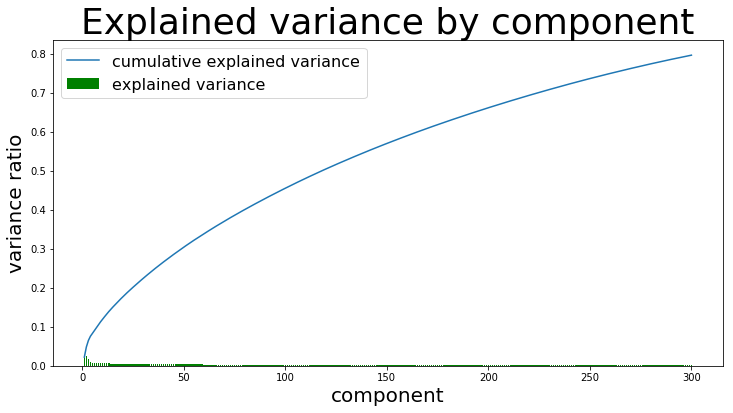

In [162]:
#visually examining the cumulative sum of the explained variance
fig = plt.figure(figsize=(12,6))
plt.bar(np.array(range(300))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(300))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=20)
plt.ylabel('variance ratio', fontsize=20)
plt.title('Explained variance by component', fontsize=36)

In [163]:
#Number of original components:
term_df.shape[1]

692

In [164]:
#Percent of components being used
300/term_df.shape[1]

0.43352601156069365

The variance hasn't really flattened out at 300 components, but perhaps the roughly 75% - 80% variance explained with 300 components is enough.  Still, this means we can represent approx. 75%-80% of what the data has to say, by only using 300 components (which is 300/692 = approx. 43.4% of the original components). 

In [165]:
#SVD.explained_variance_ratio_

In [166]:
# How many components do we need to represent at least
# %70 of the variance in the data?
np.where(np.cumsum(SVD.explained_variance_ratio_) < .7)[0][-1]+1

224

In [167]:
#Converting matrix to df for easier interpretation (for training data)
#Converting our original tfidf vectorized matrix to one where observations are represented by how they 
#exist upon the 300 found component vectors.
component_names = ["component_"+str(i+1) for i in range(300)]
svd_df_train = pd.DataFrame(svd_matrix_train,
                      columns=component_names)

svd_df_train.shape

(1497, 300)

In [168]:
#Converting matrix to df for easier interpretation (for training data)
#Converting our original tfidf vectorized matrix to one where observations are represented by how they 
#exist upon the 300 found component vectors.
component_names = ["component_"+str(i+1) for i in range(300)]
svd_df_test = pd.DataFrame(svd_matrix_test,
                      columns=component_names)

svd_df_test.shape

(500, 300)

In [169]:
svd_df_train.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,component_50,component_51,component_52,component_53,component_54,component_55,component_56,component_57,component_58,component_59,component_60,component_61,component_62,component_63,component_64,component_65,component_66,component_67,component_68,component_69,component_70,component_71,component_72,component_73,component_74,component_75,component_76,component_77,component_78,component_79,component_80,component_81,component_82,component_83,component_84,component_85,component_86,component_87,component_88,component_89,component_90,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100,component_101,component_102,component_103,component_104,component_105,component_106,component_107,component_108,component_109,component_110,component_111,component_112,component_113,component_114,component_115,component_116,component_117,component_118,component_119,component_120,component_121,component_122,component_123,component_124,component_125,component_126,component_127,component_128,component_129,component_130,component_131,component_132,component_133,component_134,component_135,component_136,component_137,component_138,component_139,component_140,component_141,component_142,component_143,component_144,component_145,component_146,component_147,component_148,component_149,component_150,component_151,component_152,component_153,component_154,component_155,component_156,component_157,component_158,component_159,component_160,component_161,component_162,component_163,component_164,component_165,component_166,component_167,component_168,component_169,component_170,component_171,component_172,component_173,component_174,component_175,component_176,component_177,component_178,component_179,component_180,component_181,component_182,component_183,component_184,component_185,component_186,component_187,component_188,component_189,component_190,component_191,component_192,component_193,component_194,component_195,component_196,component_197,component_198,component_199,component_200,component_201,component_202,component_203,component_204,component_205,component_206,component_207,component_208,component_209,component_210,component_211,component_212,component_213,component_214,component_215,component_216,component_217,component_218,component_219,component_220,component_221,component_222,component_223,component_224,component_225,component_226,component_227,component_228,component_229,component_230,component_231,component_232,component_233,component_234,component_235,component_236,component_237,component_238,component_239,component_240,component_241,component_242,component_243,component_244,component_245,component_246,component_247,component_248,component_249,component_250,component_251,component_252,component_253,component_254,component_255,component_256,component_257,component_258,component_259,component_260,component_261,component_262,component_263,component_264,component_265,component_266,component_267,component_268,component_269,component_270,component_271,component_272,component_273,component_274,component_275,component_276,component_277,component_278,component_279,component_280,component_281,component_282,component_283,component_284,component_285,component_286,component_287,component_288,component_289,component_290,component_291,component_292,component_293,compo

In [170]:
svd_df_test.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,component_50,component_51,component_52,component_53,component_54,component_55,component_56,component_57,component_58,component_59,component_60,component_61,component_62,component_63,component_64,component_65,component_66,component_67,component_68,component_69,component_70,component_71,component_72,component_73,component_74,component_75,component_76,component_77,component_78,component_79,component_80,component_81,component_82,component_83,component_84,component_85,component_86,component_87,component_88,component_89,component_90,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100,component_101,component_102,component_103,component_104,component_105,component_106,component_107,component_108,component_109,component_110,component_111,component_112,component_113,component_114,component_115,component_116,component_117,component_118,component_119,component_120,component_121,component_122,component_123,component_124,component_125,component_126,component_127,component_128,component_129,component_130,component_131,component_132,component_133,component_134,component_135,component_136,component_137,component_138,component_139,component_140,component_141,component_142,component_143,component_144,component_145,component_146,component_147,component_148,component_149,component_150,component_151,component_152,component_153,component_154,component_155,component_156,component_157,component_158,component_159,component_160,component_161,component_162,component_163,component_164,component_165,component_166,component_167,component_168,component_169,component_170,component_171,component_172,component_173,component_174,component_175,component_176,component_177,component_178,component_179,component_180,component_181,component_182,component_183,component_184,component_185,component_186,component_187,component_188,component_189,component_190,component_191,component_192,component_193,component_194,component_195,component_196,component_197,component_198,component_199,component_200,component_201,component_202,component_203,component_204,component_205,component_206,component_207,component_208,component_209,component_210,component_211,component_212,component_213,component_214,component_215,component_216,component_217,component_218,component_219,component_220,component_221,component_222,component_223,component_224,component_225,component_226,component_227,component_228,component_229,component_230,component_231,component_232,component_233,component_234,component_235,component_236,component_237,component_238,component_239,component_240,component_241,component_242,component_243,component_244,component_245,component_246,component_247,component_248,component_249,component_250,component_251,component_252,component_253,component_254,component_255,component_256,component_257,component_258,component_259,component_260,component_261,component_262,component_263,component_264,component_265,component_266,component_267,component_268,component_269,component_270,component_271,component_272,component_273,component_274,component_275,component_276,component_277,component_278,component_279,component_280,component_281,component_282,component_283,component_284,component_285,component_286,component_287,component_288,component_289,component_290,component_291,component_292,component_293,compo

In [171]:
#Making feature loadings matrix
#This will show how each of our 692 words contributes to each component.
loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=term_df.columns).T

In [172]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)

In [173]:
loadings.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,component_50,component_51,component_52,component_53,component_54,component_55,component_56,component_57,component_58,component_59,component_60,component_61,component_62,component_63,component_64,component_65,component_66,component_67,component_68,component_69,component_70,component_71,component_72,component_73,component_74,component_75,component_76,component_77,component_78,component_79,component_80,component_81,component_82,component_83,component_84,component_85,component_86,component_87,component_88,component_89,component_90,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100,component_101,component_102,component_103,component_104,component_105,component_106,component_107,component_108,component_109,component_110,component_111,component_112,component_113,component_114,component_115,component_116,component_117,component_118,component_119,component_120,component_121,component_122,component_123,component_124,component_125,component_126,component_127,component_128,component_129,component_130,component_131,component_132,component_133,component_134,component_135,component_136,component_137,component_138,component_139,component_140,component_141,component_142,component_143,component_144,component_145,component_146,component_147,component_148,component_149,component_150,component_151,component_152,component_153,component_154,component_155,component_156,component_157,component_158,component_159,component_160,component_161,component_162,component_163,component_164,component_165,component_166,component_167,component_168,component_169,component_170,component_171,component_172,component_173,component_174,component_175,component_176,component_177,component_178,component_179,component_180,component_181,component_182,component_183,component_184,component_185,component_186,component_187,component_188,component_189,component_190,component_191,component_192,component_193,component_194,component_195,component_196,component_197,component_198,component_199,component_200,component_201,component_202,component_203,component_204,component_205,component_206,component_207,component_208,component_209,component_210,component_211,component_212,component_213,component_214,component_215,component_216,component_217,component_218,component_219,component_220,component_221,component_222,component_223,component_224,component_225,component_226,component_227,component_228,component_229,component_230,component_231,component_232,component_233,component_234,component_235,component_236,component_237,component_238,component_239,component_240,component_241,component_242,component_243,component_244,component_245,component_246,component_247,component_248,component_249,component_250,component_251,component_252,component_253,component_254,component_255,component_256,component_257,component_258,component_259,component_260,component_261,component_262,component_263,component_264,component_265,component_266,component_267,component_268,component_269,component_270,component_271,component_272,component_273,component_274,component_275,component_276,component_277,component_278,component_279,component_280,component_281,component_282,component_283,component_284,component_285,component_286,component_287,component_288,component_289,component_290,component_291,component_292,component_293,compo

In [174]:
# Top 10 words that contributes to component 1
loadings.sort_values('abs_component_1',ascending=False).head(10)[['component_1']]

,component_1
climate,0.689844
change,0.598830
new,0.170319
green,0.133411
science,0.127826
deal,0.124091
global,0.076294
scientist,0.061103
warming,0.057777
trump,0.057337


In [175]:
# Top 10 components that contribute to Topic 2
loadings.sort_values('abs_component_2',ascending=False).head(10)[['component_2']]

,component_2
green,0.585940
new,0.525622
deal,0.523493
change,-0.188532
climate,-0.187182
science,-0.047527
energy,0.042567
need,0.041791
aoc,0.041391
senator,0.039034


#### Precomputing full cosine similarity matrix for fast access

The cosine similarity will be used to compute how similar observations are to one another. 

In [176]:
#Importing cosine_similarity library:
from sklearn.metrics.pairwise import cosine_similarity

# This is a sqare matrix showing how similar every observation is to every other observation.
# The diagonal top-left to bottom-right will be 1 for every row
# as this is the similarity of an observation to itself.
cos_sim_mat_train = cosine_similarity(svd_matrix_train, svd_matrix_train)
cos_sim_mat_train.shape

(1497, 1497)

In [177]:
#Generating cosine similarity matrix for test data:
cos_sim_mat_test = cosine_similarity(svd_matrix_test, svd_matrix_test)
cos_sim_mat_test.shape

(500, 500)

#### Using np.argsort to see the most similar post to a given post

In [178]:
df.iloc[1]['title_preprocessed']

'global carbon emission hit record high 2018 international energy agency say'

In [179]:
df.iloc[-2]['title_preprocessed']

'1970 global cooling scare'

In [180]:
#Inspecting 1st row of cos_sim_mat_train
#cos_sim_mat_train[1]
len(cos_sim_mat_train[1])

1497

In [181]:
#Inspecting 1st row of cos_sim_mat_test
#cos_sim_mat_test[1]
len(cos_sim_mat_test[1])

500

In [182]:
#Sorting the first rows in ascending order so most similar observations will be towards the rear
#This is returning index/column positions.
np.argsort(cos_sim_mat_train[1])[:-11:-1]

array([   1,   57,  777,   89, 1372,  147,  281,   32,  978,  153])

In [183]:
df['title_preprocessed'].iloc[89]

'yes greenland glacier growing mean melting'

In [184]:
np.sort(cos_sim_mat_train[1])[:-11:-1]

array([1.        , 1.        , 1.        , 1.        , 0.6525704 ,
       0.63021142, 0.61277004, 0.6101787 , 0.5881686 , 0.49766731])

Plugging these indices back into the original dataframe to see which posts are similar

In [185]:
#Looking at subreddit post titles that are similar to the post title at index 1
df.loc[np.argsort(cos_sim_mat_train[1])[:-11:-1], :]

,title,full_post,permalink,post_text,full_comments_page_each_post,skeptic,char_count,word_count,title_preprocessed
1,Global carbon emissions hit record high in 201...,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b82tsw/global_carbon_emiss...,,[],0,81,12,global carbon emission hit record high 2018 in...
57,"Dad Recently sent me this video, and I could u...","{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b6c0bg/dad_recently_sent_m...,[https://www.youtube.com/watch?v=Np\_CHy9ql4M...,"[{'kind': 't1', 'data': {'subreddit_id': 't5_2...",0,83,16,dad recently sent video could use help disprov...
777,“The Age of Climate Panic Is Here”,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/as6in5/the_age_of_climate_...,,"[{'kind': 't1', 'data': {'subreddit_id': 't5_2...",0,34,7,age climate panic
89,"Yes, a Greenland glacier is growing. No, that ...","{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b5o5gh/yes_a_greenland_gla...,,"[{'kind': 't1', 'data': {'subreddit_id': 't5_2...",0,80,14,yes greenland glacier growing mean melting
1372,5-Sigma = Santer bullshit,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climateskeptics/comments/aw509q/5sigma_sant...,"[Here is a link to the recent Santer et all ""s...",[],1,25,4,5 sigma santer bullshit
147,Cyclone Shows Climate Change’s Deadly Impact o...,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b480ne/cyclone_shows_clima...,,"[{'kind': 't1', 'data': {'subreddit_id': 't5_2...",0,72,10,cyclone show climate change deadly impact poor...
281,Youth movement in Eugene OR,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b1kmzz/youth_movement_in_e...,,"[{'kind': 't1', 'data': {'subreddit_id': 't5_2...",0,27,5,youth movement eugene
32,"ABC, CBS, and NBC completely failed to mention...","{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b72yot/abc_cbs_and_nbc_com...,,"[{'kind': 't1', 'data': {'subreddit_id': 't5_2...",0,97,16,abc cbs nbc completely failed mention climate ...
978,‘It’s no longer free to pollute’: Canada impos...,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b8itah/its_no_longer_free_...,,"[{'kind': 't1', 'data': {'subreddit_id': 't5_2...",0,77,13,longer free pollute canada imposes carbon tax ...
153,Donald Trump is using Stalinist techniques aga...,"{'kind': 't3', 'data': {'approved_at_utc': Non...",/r/climate/comments/b3xzio/donald_trump_is_usi...,,[],0,94,15,donald trump using stalinist technique climate...


It is interesting that subreddit post title (that is preprocessed) in index 1 is perfectly similar to the subreddit post titles (that are preprocessed) in indexes 89, 87, and 777 (all have cosine similarity values of 1).  Note that these posts are all from the r/climate subreddit (climate change believers).

#### Logistic Regression Model of SVD-Transformed Data

In [186]:
#Instantiating LogisticRegression
logreg = LogisticRegression(solver = 'lbfgs', multi_class = 'auto')

#Fitting the LogisticRegression model:
logreg.fit(svd_df_train, y_train)

#Generating predictions on test data:
predictions = logreg.predict(svd_df_test)

#Scores (accuracies): 
print('Cross-validation score:', cross_val_score(logreg, svd_df_train, y_train, cv=3).mean())
print('Train score:', logreg.score(svd_df_train, y_train))
print('Test score:', logreg.score(svd_df_test, y_test))

#Sources:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

Cross-validation score: 0.6713351307702419
Train score: 0.7802271209084837
Test score: 0.682


When logistic regression is performed on SVD-transformed preprocessed subreddit posts, the cross-validation score slightly decreased, the train score significantly decreased, and the test score increased.  This means that the model variance decreased (it became less overfit to the training data).

Logistic regression on SVD-transformed post titles:
Cross-validation score: approx. 0.675
Train score: approx. 0.781
Test score: 0.696

Logistic regression on count vectorized post titles:
Cross-validation score: approx. 0.677
Train score: approx. 0.841
Test score: 0.664

Scores (representing accuracy) when use Naive Bayes to model count vectorized preprocessed post titles:
Cross-validation score: approx. 0.657
Train score: approx. 0.769
Test score: 0.676

Baseline accuracy: approx. 0.502 (definitely surpassed the baseline accuracy)

#### Using GridSearchCV to find hyperparameters that help the model perform better

In [187]:
gs = GridSearchCV(LogisticRegression(random_state = 42),  
                  {#Regularization penalty:
                  'penalty':['l1', 'l2'],
                  #Inverse of regularization strength (smaller values mean stronger regularization
                  'C': [0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 1]},
                  cv=3) 

#Source:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [188]:
gs.fit(svd_df_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [189]:
gs.best_params_

{'C': 0.5, 'penalty': 'l2'}

In [190]:
#Scores (accuracies): 
print('Cross-validation score:', cross_val_score(gs, svd_df_train, y_train, cv=3).mean())
print('Train score:', gs.score(svd_df_train, y_train))
print('Test score:', gs.score(svd_df_test, y_test))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Cross-validation score: 0.6719991093297706
Train score: 0.7702070808283233
Test score: 0.678


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


When logistic regression is performed on SVD-transformed preprocessed subreddit posts utilizing GridSearch best_params_, the cross-validation score slightly decreased, the train score decreased, and the test score slightly increased.  This means that the model variance decreased (the model became less overfit to the training data).

Logistic regression on SVD-transformed post titles utilizing GridSearch best_params_:
Cross-validation score: approx. 0.668
Train score: approx. 0.774
Test score: 0.698

Logistic regression on SVD-transformed post titles:
Cross-validation score: approx. 0.675
Train score: approx. 0.781
Test score: 0.696

Logistic regression on count vectorized post titles:
Cross-validation score: approx. 0.677
Train score: approx. 0.841
Test score: 0.664

Scores (representing accuracy) when use Naive Bayes to model count vectorized preprocessed post titles:
Cross-validation score: approx. 0.657
Train score: approx. 0.769
Test score: 0.676

Baseline accuracy: approx. 0.502 (definitely surpassed the baseline accuracy)

In [191]:
#Generating predictions
y_pred = gs.predict(svd_df_test)

In [192]:
#Looking at first 5 values of y_pred:
y_pred[0:5]

array([1, 0, 1, 1, 1])

In [193]:
#Inspecting datatypes of df at the end of analysis:
df.dtypes

title                           object
full_post                       object
permalink                       object
post_text                       object
full_comments_page_each_post    object
skeptic                          int64
char_count                       int64
word_count                       int64
title_preprocessed              object
dtype: object